In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [36]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [37]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [38]:
tree_names = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [39]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [42]:
files[3].aliases = {
    'B_FD_TRUE': "D_FD_TRUE",
    "B_SIGMAIP_TRUE": "D_SIGMAIP_TRUE",
}

In [43]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'B_SIGMAIP_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [44]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [45]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [46]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [47]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [48]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [49]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [50]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [51]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          955868   243424  194739   48685       0.254663
B⁺→K⁺J/ψ(→ee)    946366   916346  733076  183270       0.968279
B⁺→K⁺ψ(2S)(→ee)  972093   926218  740974  185244       0.952808
D⁺→π⁺φ(→ee)      822647   822647  658117  164530            1.0

### KS tests

In [52]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [53]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [54]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [55]:
aliases = {
    "min_e_IP": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT": "fmax(ep_PT_TRUE,em_PT_TRUE)",
}

In [57]:
np.unique(files[0].get(["B_IP"]))

array([0.])

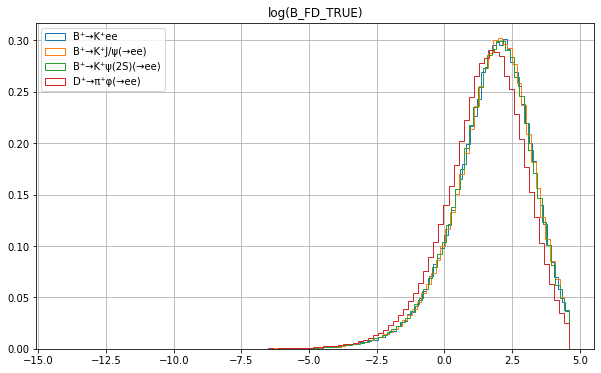

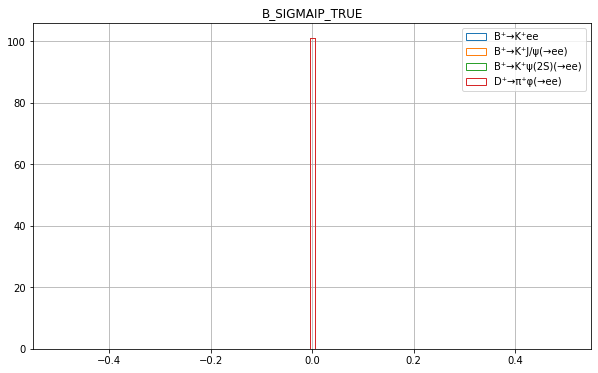

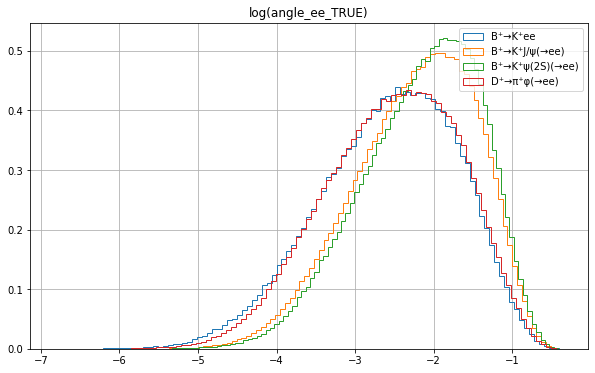

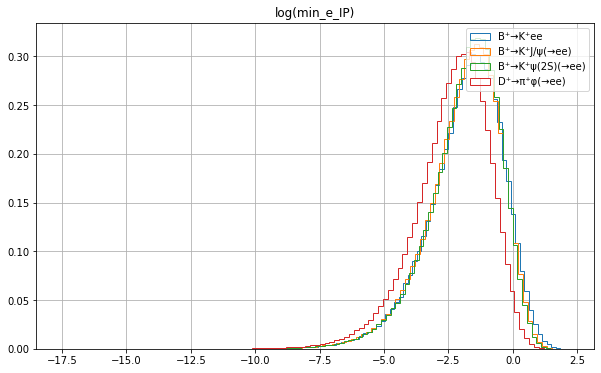

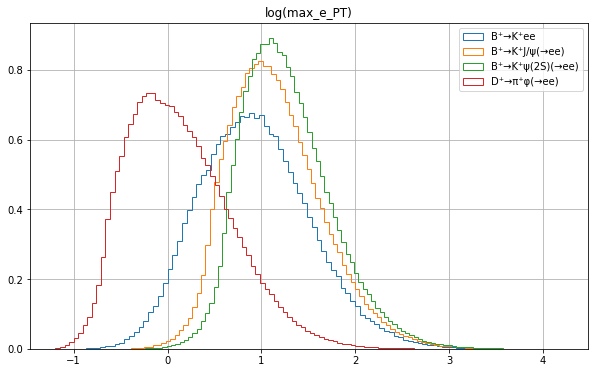

In [58]:
feature_plot("log(B_FD_TRUE)", train_ds, aliases, 101)
#feature_plot("log(D_FD_TRUE)", train_ds, aliases, 101)
feature_plot("B_SIGMAIP_TRUE", train_ds, aliases, 101)
#feature_plot("D_SIGMAIP_TRUE", train_ds, aliases, 101)
feature_plot("log(angle_ee_TRUE)", train_ds, aliases, 101)
feature_plot("log(min_e_IP)", train_ds, aliases, 101)
feature_plot("log(max_e_PT)", train_ds, aliases, 101)

### Preprocessing

In [59]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [60]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [61]:
feature_sets = [
    ("ee", ["log(min_e_IP)", "log(max_e_PT)"]),
    ("Bα", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)"]),
    ("4", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)", "log(min_e_IP)", "log(max_e_PT)"]),
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[ee], DS₃[ee], DS₄[Bα], DS₃[Bα], DS₄[4], DS₃[4]]

In [62]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [63]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

ValueError: too many values to unpack (expected 2)

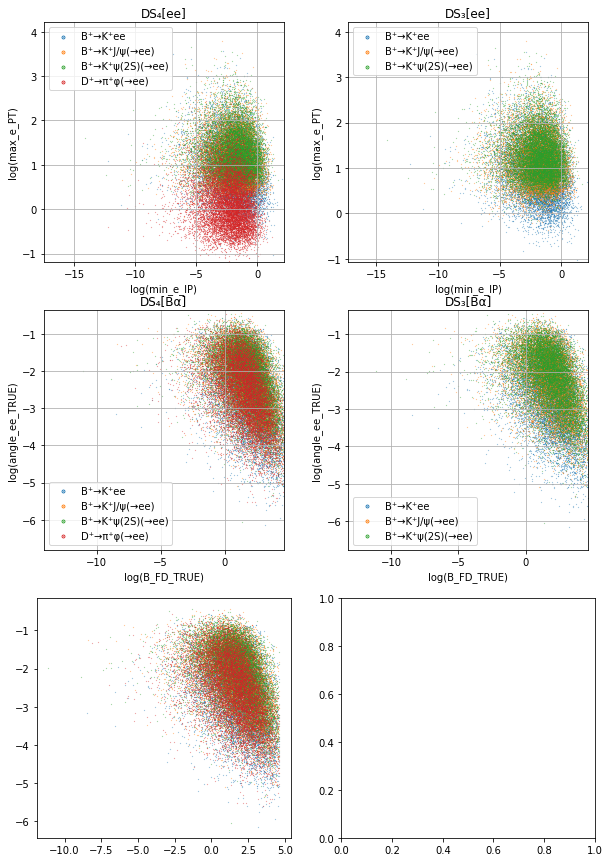

In [64]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(6):
    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
plt.show()

### NN

In [65]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [66]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [67]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [68]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [69]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.385958
INFO:root:Epoch 1, 1.359761
INFO:root:Epoch 2, 1.298277
INFO:root:Epoch 3, 1.181666
INFO:root:Epoch 4, 1.114984
INFO:root:Epoch 5, 1.106895
INFO:root:Epoch 6, 1.103167
INFO:root:Epoch 7, 1.100163
INFO:root:Epoch 8, 1.097558
INFO:root:Epoch 9, 1.095253
INFO:root:Epoch 10, 1.093219
INFO:root:Epoch 11, 1.091426
INFO:root:Epoch 12, 1.089855
INFO:root:Epoch 13, 1.088488
INFO:root:Epoch 14, 1.087230
INFO:root:Epoch 15, 1.086109
INFO:root:Epoch 16, 1.085215
INFO:root:Epoch 17, 1.084559
INFO:root:Epoch 18, 1.084154
INFO:root:Epoch 19, 1.083886
INFO:root:Epoch 20, 1.083677
INFO:root:Epoch 21, 1.083558
INFO:root:Epoch 22, 1.083380
INFO:root:Epoch 23, 1.083223
INFO:root:Epoch 24, 1.083058
INFO:root:Epoch 25, 1.082932
INFO:root:Epoch 26, 1.082894
INFO:root:Epoch 27, 1.082734
INFO:root:Epoch 28, 1.082648
INFO:root:Epoch 29, 1.082561
INFO:root:Epoch 30, 1.082485
INFO:root:Epoch 31, 1.082417
INFO:root:Epoch 32, 1.082336
INFO:root:Epoch 33, 1.082287
INFO:root:Epoch 34, 1.08

INFO:root:Epoch 35, 1.342643
INFO:root:Epoch 36, 1.342643
INFO:root:Epoch 37, 1.342637
INFO:root:Epoch 38, 1.342631
INFO:root:Epoch 39, 1.342630
INFO:root:Epoch 40, 1.342632
INFO:root:Epoch 41, 1.342632
INFO:root:Epoch 42, 1.342627
INFO:root:Epoch 43, 1.342623
INFO:root:Epoch 44, 1.342622
INFO:root:Epoch 45, 1.342623
INFO:root:Epoch 46, 1.342621
INFO:root:Epoch 47, 1.342618
INFO:root:Epoch 48, 1.342615
INFO:root:Epoch 49, 1.342614
INFO:root:Epoch 0, 1.111158
INFO:root:Epoch 1, 1.097587
INFO:root:Epoch 2, 1.093991
INFO:root:Epoch 3, 1.090607
INFO:root:Epoch 4, 1.085778
INFO:root:Epoch 5, 1.079209
INFO:root:Epoch 6, 1.072512
INFO:root:Epoch 7, 1.069224
INFO:root:Epoch 8, 1.068804
INFO:root:Epoch 9, 1.068598
INFO:root:Epoch 10, 1.068440
INFO:root:Epoch 11, 1.068276
INFO:root:Epoch 12, 1.068122
INFO:root:Epoch 13, 1.067996
INFO:root:Epoch 14, 1.067871
INFO:root:Epoch 15, 1.067747
INFO:root:Epoch 16, 1.067627
INFO:root:Epoch 17, 1.067522
INFO:root:Epoch 18, 1.067423
INFO:root:Epoch 19, 1.06

INFO:root:Epoch 20, 0.932531
INFO:root:Epoch 21, 0.932424
INFO:root:Epoch 22, 0.932362
INFO:root:Epoch 23, 0.932378
INFO:root:Epoch 24, 0.932411
INFO:root:Epoch 25, 0.932391
INFO:root:Epoch 26, 0.932324
INFO:root:Epoch 27, 0.932268
INFO:root:Epoch 28, 0.932260
INFO:root:Epoch 29, 0.932274
INFO:root:Epoch 30, 0.932260
INFO:root:Epoch 31, 0.932214
INFO:root:Epoch 32, 0.932169
INFO:root:Epoch 33, 0.932153
INFO:root:Epoch 34, 0.932152
INFO:root:Epoch 35, 0.932136
INFO:root:Epoch 36, 0.932100
INFO:root:Epoch 37, 0.932064
INFO:root:Epoch 38, 0.932045
INFO:root:Epoch 39, 0.932036
INFO:root:Epoch 40, 0.932017
INFO:root:Epoch 41, 0.931985
INFO:root:Epoch 42, 0.931955
INFO:root:Epoch 43, 0.931936
INFO:root:Epoch 44, 0.931921
INFO:root:Epoch 45, 0.931899
INFO:root:Epoch 46, 0.931869
INFO:root:Epoch 47, 0.931843
INFO:root:Epoch 48, 0.931823
INFO:root:Epoch 49, 0.931804


CPU times: user 3min 2s, sys: 12 s, total: 3min 14s
Wall time: 3min 12s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [70]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [71]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [72]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [73]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

ValueError: too many values to unpack (expected 2)

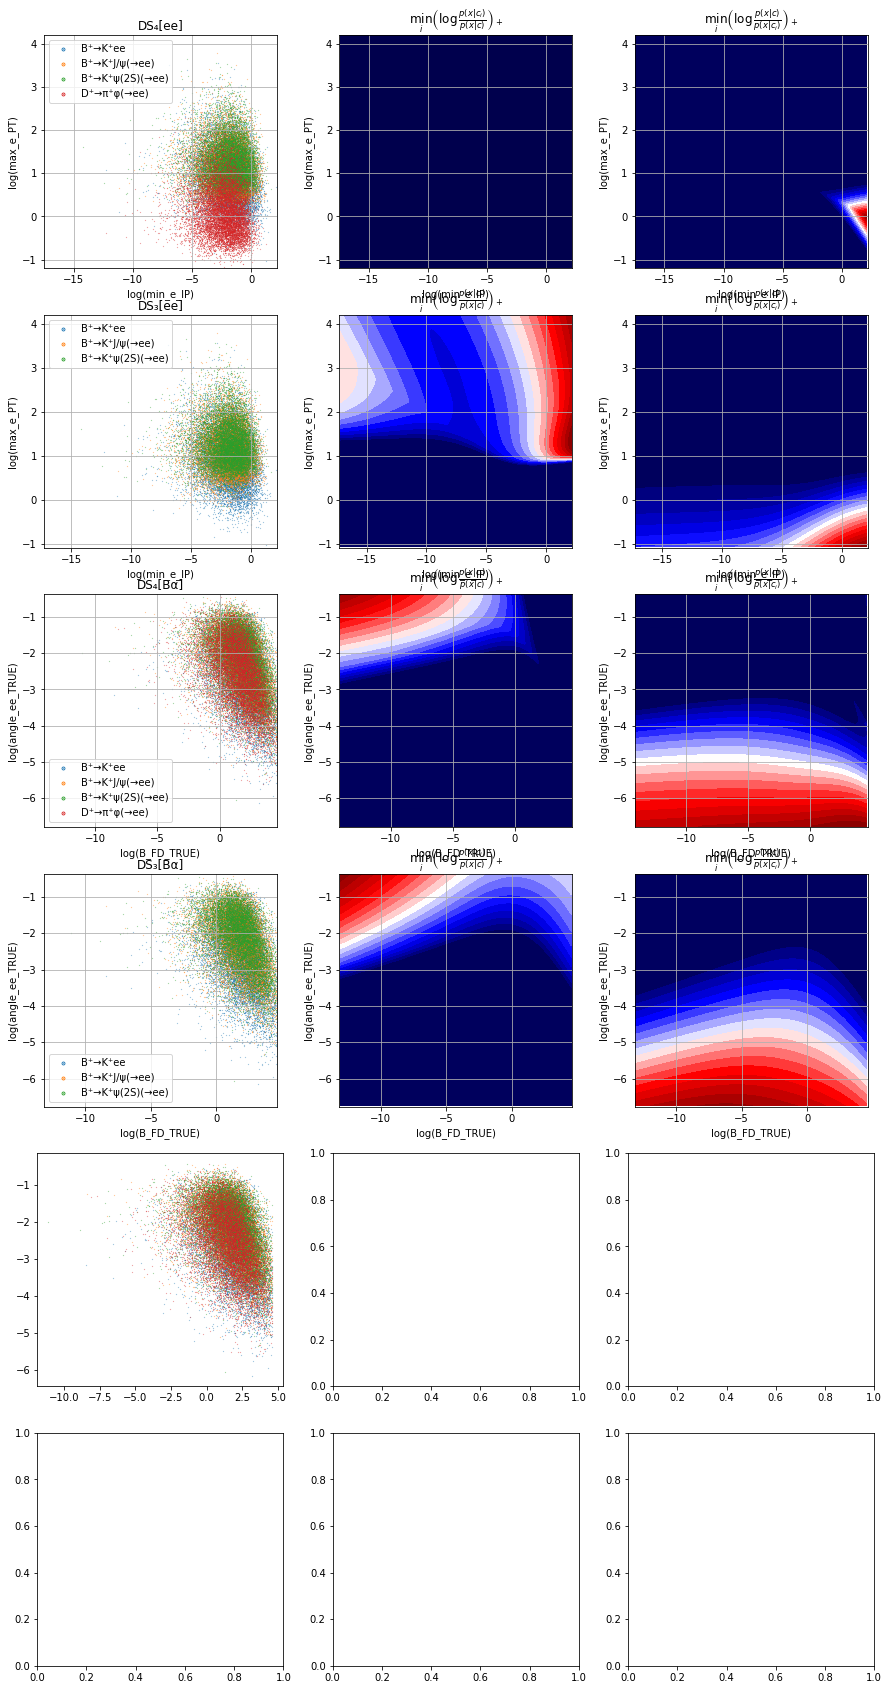

In [74]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
for i in range(6):
    est = all_est[i]
    ds = all_datasets[i]
    plot_ds(ds, scaler=est[0], ax=ax[i,0])
    plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
plt.show()

### Weighting function

In [75]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [76]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [77]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [78]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [79]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [80]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [81]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [82]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [83]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [84]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000009 W+c=[ 37.9718 -69.1865  36.1727  -4.1771] det=0.000000 L=0.077631
Epoch 1 loss=-4.000009 W+c=[ 37.8416 -68.7525  35.723   -4.1839] det=0.000000 L=0.077609
Epoch 2 loss=-4.000010 W+c=[ 37.7131 -68.3256  35.2831  -4.1908] det=0.000000 L=0.077586
Epoch 3 loss=-4.000009 W+c=[ 37.5866 -67.9066  34.8536  -4.1978] det=0.000000 L=0.077564
Epoch 4 loss=-4.000010 W+c=[ 37.4621 -67.4956  34.4342  -4.2048] det=0.000000 L=0.077543
Epoch 5 loss=-4.000002 W+c=[ 37.3391 -67.0906  34.0235  -4.2119] det=0.000000 L=0.077522
Epoch 6 loss=-4.000003 W+c=[ 37.2181 -66.6935  33.6225  -4.2191] det=0.000000 L=0.077501
Epoch 7 loss=-4.000006 W+c=[ 37.0989 -66.3032  33.2305  -4.2264] det=0.000000 L=0.077480
Epoch 8 loss=-4.000002 W+c=[ 36.9815 -65.9195  32.847   -4.2337] det=0.000000 L=0.077461
Epoch 9 loss=-4.000005 W+c=[ 36.8658 -65.5425  32.472   -4.241 ] det=0.000000 L=0.077441
Epoch 10 loss=-4.000002 W+c=[ 36.7517 -65.1715  32.1049  -4.2485] det=0.000000 L=0.077422
Epoch 11 loss=-4.000

Epoch 92 loss=-4.000007 W+c=[ 30.7902 -46.5183  16.4069  -4.9257] det=0.000000 L=0.076656
Epoch 93 loss=-4.000005 W+c=[ 30.7435 -46.3725  16.3081  -4.934 ] det=0.000000 L=0.076653
Epoch 94 loss=-4.000014 W+c=[ 30.6973 -46.2283  16.2108  -4.9422] det=0.000000 L=0.076651
Epoch 95 loss=-4.000010 W+c=[ 30.6514 -46.085   16.1145  -4.9504] det=0.000000 L=0.076649
Epoch 96 loss=-4.000003 W+c=[ 30.6058 -45.9425  16.0192  -4.9586] det=0.000000 L=0.076648
Epoch 97 loss=-3.999999 W+c=[ 30.5606 -45.8012  15.925   -4.9668] det=0.000000 L=0.076646
Epoch 98 loss=-4.000016 W+c=[ 30.5161 -45.6617  15.8323  -4.975 ] det=0.000000 L=0.076644
Epoch 99 loss=-4.000011 W+c=[ 30.4717 -45.5227  15.7404  -4.9832] det=0.000000 L=0.076643
Epoch 100 loss=-4.000016 W+c=[ 30.4278 -45.3849  15.6497  -4.9914] det=0.000000 L=0.076641
Epoch 101 loss=-4.000003 W+c=[ 30.384  -45.2477  15.5597  -4.9995] det=0.000000 L=0.076640
Epoch 102 loss=-4.000006 W+c=[ 30.3407 -45.1119  15.471   -5.0076] det=0.000000 L=0.076639
Epoch 1

Epoch 183 loss=-4.000007 W+c=[ 27.746  -36.6402  10.6436  -5.6045] det=0.000000 L=0.076857
Epoch 184 loss=-4.000010 W+c=[ 27.7224 -36.5587  10.6039  -5.611 ] det=0.000000 L=0.076863
Epoch 185 loss=-4.000011 W+c=[ 27.6989 -36.4777  10.5646  -5.6174] det=0.000000 L=0.076869
Epoch 186 loss=-4.000012 W+c=[ 27.6756 -36.397   10.5256  -5.6239] det=0.000000 L=0.076875
Epoch 187 loss=-4.000010 W+c=[ 27.6524 -36.3167  10.4868  -5.6303] det=0.000000 L=0.076881
Epoch 188 loss=-4.000010 W+c=[ 27.6293 -36.2368  10.4484  -5.6367] det=0.000000 L=0.076887
Epoch 189 loss=-4.000009 W+c=[ 27.6064 -36.1575  10.4104  -5.6431] det=0.000000 L=0.076894
Epoch 190 loss=-4.000008 W+c=[ 27.5837 -36.0784  10.3726  -5.6494] det=0.000000 L=0.076900
Epoch 191 loss=-4.000007 W+c=[ 27.561  -35.9997  10.3351  -5.6557] det=0.000000 L=0.076907
Epoch 192 loss=-4.000010 W+c=[ 27.5386 -35.9215  10.298   -5.662 ] det=0.000000 L=0.076913
Epoch 193 loss=-4.000010 W+c=[ 27.5163 -35.8438  10.2611  -5.6683] det=0.000000 L=0.076920

Epoch 71 loss=-7.863462 W+c=[ 30.8638 -15.6828   6.4585  -7.1808] det=0.000000 L=0.106270
Epoch 72 loss=-7.860316 W+c=[ 30.8984 -15.577    6.4376  -7.1759] det=0.000000 L=0.107109
Epoch 73 loss=-7.857264 W+c=[ 30.9325 -15.4732   6.4172  -7.1706] det=0.000000 L=0.107946
Epoch 74 loss=-7.854270 W+c=[ 30.9658 -15.3711   6.3971  -7.1648] det=0.000000 L=0.108782
Epoch 75 loss=-7.851364 W+c=[ 30.9986 -15.2709   6.3773  -7.1586] det=0.000000 L=0.109615
Epoch 76 loss=-7.848534 W+c=[ 31.0307 -15.1724   6.3578  -7.152 ] det=0.000000 L=0.110448
Epoch 77 loss=-7.845777 W+c=[ 31.0622 -15.0756   6.3387  -7.1451] det=0.000000 L=0.111278
Epoch 78 loss=-7.843100 W+c=[ 31.093  -14.9804   6.3198  -7.1378] det=0.000000 L=0.112107
Epoch 79 loss=-7.840489 W+c=[ 31.1233 -14.8869   6.3013  -7.1301] det=0.000000 L=0.112935
Epoch 80 loss=-7.837939 W+c=[ 31.1528 -14.7948   6.283   -7.122 ] det=0.000000 L=0.113762
Epoch 81 loss=-7.835473 W+c=[ 31.1818 -14.7043   6.265   -7.1137] det=0.000000 L=0.114588
Epoch 82 l

Epoch 162 loss=-7.764657 W+c=[ 32.1923 -10.1411   5.3109  -5.961 ] det=0.000000 L=0.185601
Epoch 163 loss=-7.764504 W+c=[ 32.1955 -10.1039   5.3024  -5.9456] det=0.000000 L=0.186562
Epoch 164 loss=-7.764343 W+c=[ 32.1987 -10.067    5.2938  -5.9303] det=0.000000 L=0.187524
Epoch 165 loss=-7.764191 W+c=[ 32.2018 -10.0303   5.2854  -5.915 ] det=0.000000 L=0.188489
Epoch 166 loss=-7.764047 W+c=[32.2048 -9.994   5.277  -5.8997] det=0.000000 L=0.189456
Epoch 167 loss=-7.763898 W+c=[32.2076 -9.9578  5.2686 -5.8845] det=0.000000 L=0.190426
Epoch 168 loss=-7.763758 W+c=[32.2104 -9.9219  5.2603 -5.8693] det=0.000000 L=0.191400
Epoch 169 loss=-7.763618 W+c=[32.2132 -9.8863  5.252  -5.8542] det=0.000000 L=0.192373
Epoch 170 loss=-7.763483 W+c=[32.2158 -9.851   5.2438 -5.839 ] det=0.000000 L=0.193352
Epoch 171 loss=-7.763340 W+c=[32.2184 -9.8158  5.2355 -5.824 ] det=0.000000 L=0.194331
Epoch 172 loss=-7.763204 W+c=[32.2209 -9.7809  5.2273 -5.8089] det=0.000000 L=0.195314
Epoch 173 loss=-7.763069 W+

Epoch 256 loss=-7.742146 W+c=[32.3339 -7.4929  4.6205 -4.703 ] det=0.000000 L=0.290952
Epoch 257 loss=-7.741690 W+c=[32.3352 -7.4714  4.6139 -4.6918] det=0.000000 L=0.292244
Epoch 258 loss=-7.741236 W+c=[32.3366 -7.4501  4.6074 -4.6805] det=0.000000 L=0.293540
Epoch 259 loss=-7.740768 W+c=[32.3379 -7.4289  4.6009 -4.6694] det=0.000000 L=0.294839
Epoch 260 loss=-7.740308 W+c=[32.3393 -7.4078  4.5943 -4.6582] det=0.000000 L=0.296143
Epoch 261 loss=-7.739831 W+c=[32.3407 -7.3868  4.5878 -4.6471] det=0.000000 L=0.297448
Epoch 262 loss=-7.739351 W+c=[32.3421 -7.366   4.5813 -4.6361] det=0.000000 L=0.298760
Epoch 263 loss=-7.738866 W+c=[32.3435 -7.3452  4.5749 -4.6251] det=0.000000 L=0.300073
Epoch 264 loss=-7.738369 W+c=[32.345  -7.3245  4.5684 -4.6141] det=0.000000 L=0.301390
Epoch 265 loss=-7.737883 W+c=[32.3464 -7.3039  4.5619 -4.6032] det=0.000000 L=0.302711
Epoch 266 loss=-7.737379 W+c=[32.3479 -7.2835  4.5555 -4.5923] det=0.000000 L=0.304036
Epoch 267 loss=-7.736875 W+c=[32.3494 -7.26

Epoch 351 loss=-7.677573 W+c=[32.5311 -5.851   4.0446 -3.7977] det=0.000000 L=0.429403
Epoch 352 loss=-7.676701 W+c=[32.5338 -5.8372  4.0389 -3.7897] det=0.000000 L=0.431022
Epoch 353 loss=-7.675826 W+c=[32.5367 -5.8235  4.0334 -3.7817] det=0.000000 L=0.432661
Epoch 354 loss=-7.674942 W+c=[32.5395 -5.8098  4.0278 -3.7738] det=0.000000 L=0.434310
Epoch 355 loss=-7.674057 W+c=[32.5424 -5.7961  4.0222 -3.7659] det=0.000000 L=0.435962
Epoch 356 loss=-7.673172 W+c=[32.5452 -5.7825  4.0166 -3.758 ] det=0.000000 L=0.437618
Epoch 357 loss=-7.672280 W+c=[32.5481 -5.769   4.0111 -3.7502] det=0.000000 L=0.439277
Epoch 358 loss=-7.671386 W+c=[32.551  -5.7555  4.0055 -3.7423] det=0.000000 L=0.440940
Epoch 359 loss=-7.670491 W+c=[32.5539 -5.7421  4.     -3.7345] det=0.000000 L=0.442606
Epoch 360 loss=-7.669587 W+c=[32.5567 -5.7287  3.9944 -3.7268] det=0.000000 L=0.444276
Epoch 361 loss=-7.668686 W+c=[32.5597 -5.7155  3.9889 -3.719 ] det=0.000000 L=0.445948
Epoch 362 loss=-7.667785 W+c=[32.5626 -5.70

Epoch 446 loss=-7.583802 W+c=[32.8439 -4.7623  3.5515 -3.1472] det=0.000000 L=0.608578
Epoch 447 loss=-7.582732 W+c=[32.8476 -4.7529  3.5467 -3.1414] det=0.000000 L=0.610690
Epoch 448 loss=-7.581669 W+c=[32.8513 -4.7435  3.542  -3.1356] det=0.000000 L=0.612807
Epoch 449 loss=-7.580595 W+c=[32.855  -4.7341  3.5372 -3.1298] det=0.000000 L=0.614927
Epoch 450 loss=-7.579528 W+c=[32.8586 -4.7248  3.5325 -3.124 ] det=0.000000 L=0.617051
Epoch 451 loss=-7.578454 W+c=[32.8624 -4.7155  3.5277 -3.1183] det=0.000000 L=0.619177
Epoch 452 loss=-7.577382 W+c=[32.866  -4.7063  3.523  -3.1125] det=0.000000 L=0.621310
Epoch 453 loss=-7.576310 W+c=[32.8697 -4.6971  3.5183 -3.1068] det=0.000000 L=0.623445
Epoch 454 loss=-7.575243 W+c=[32.8735 -4.6879  3.5136 -3.1011] det=0.000000 L=0.625584
Epoch 455 loss=-7.574162 W+c=[32.8772 -4.6788  3.5089 -3.0954] det=0.000000 L=0.627726
Epoch 456 loss=-7.573090 W+c=[32.8809 -4.6696  3.5042 -3.0898] det=0.000000 L=0.629873
Epoch 457 loss=-7.572010 W+c=[32.8846 -4.66

Epoch 39 loss=-3.000012 W+c=[ 12.1693 -23.4536  13.9496] det=0.000001 L=0.047224
Epoch 40 loss=-3.000017 W+c=[ 12.1687 -23.3769  13.9082] det=0.000001 L=0.047265
Epoch 41 loss=-3.000014 W+c=[ 12.1681 -23.3008  13.867 ] det=0.000001 L=0.047306
Epoch 42 loss=-3.000015 W+c=[ 12.1675 -23.2254  13.8263] det=0.000001 L=0.047347
Epoch 43 loss=-3.000006 W+c=[ 12.1668 -23.1503  13.7855] det=0.000001 L=0.047387
Epoch 44 loss=-3.000009 W+c=[ 12.1663 -23.0762  13.7455] det=0.000001 L=0.047428
Epoch 45 loss=-3.000004 W+c=[ 12.1657 -23.0025  13.7055] det=0.000001 L=0.047469
Epoch 46 loss=-3.000006 W+c=[ 12.1651 -22.9296  13.666 ] det=0.000001 L=0.047509
Epoch 47 loss=-3.000014 W+c=[ 12.1645 -22.8573  13.6268] det=0.000001 L=0.047550
Epoch 48 loss=-3.000012 W+c=[ 12.1639 -22.7854  13.5877] det=0.000001 L=0.047591
Epoch 49 loss=-3.000013 W+c=[ 12.1634 -22.7142  13.5491] det=0.000001 L=0.047631
Epoch 50 loss=-3.000017 W+c=[ 12.1628 -22.6437  13.5107] det=0.000001 L=0.047672
Epoch 51 loss=-3.000011 W+c=

Epoch 140 loss=-3.000013 W+c=[ 12.0966 -18.0266  10.9393] det=0.000001 L=0.051279
Epoch 141 loss=-3.000010 W+c=[ 12.0956 -17.9894  10.918 ] det=0.000001 L=0.051319
Epoch 142 loss=-3.000014 W+c=[ 12.0946 -17.9525  10.8969] det=0.000001 L=0.051359
Epoch 143 loss=-3.000012 W+c=[ 12.0935 -17.9158  10.8758] det=0.000001 L=0.051399
Epoch 144 loss=-3.000013 W+c=[ 12.0925 -17.8793  10.8549] det=0.000001 L=0.051438
Epoch 145 loss=-3.000014 W+c=[ 12.0914 -17.8431  10.8341] det=0.000001 L=0.051478
Epoch 146 loss=-3.000013 W+c=[ 12.0904 -17.807   10.8134] det=0.000001 L=0.051518
Epoch 147 loss=-3.000014 W+c=[ 12.0893 -17.7712  10.7929] det=0.000001 L=0.051558
Epoch 148 loss=-3.000015 W+c=[ 12.0882 -17.7356  10.7724] det=0.000001 L=0.051598
Epoch 149 loss=-3.000015 W+c=[ 12.0871 -17.7001  10.752 ] det=0.000001 L=0.051638
Epoch 150 loss=-3.000012 W+c=[ 12.086  -17.665   10.7318] det=0.000001 L=0.051678
Epoch 151 loss=-3.000011 W+c=[ 12.0849 -17.6299  10.7117] det=0.000001 L=0.051718
Epoch 152 loss=-

Epoch 39 loss=-7.092459 W+c=[16.8625 -7.7273  5.2417] det=0.000001 L=0.078264
Epoch 40 loss=-7.067087 W+c=[16.939  -7.6511  5.2041] det=0.000001 L=0.079113
Epoch 41 loss=-7.042727 W+c=[17.0128 -7.5773  5.1683] det=0.000001 L=0.079943
Epoch 42 loss=-7.019362 W+c=[17.084  -7.5058  5.1342] det=0.000001 L=0.080756
Epoch 43 loss=-6.996920 W+c=[17.1525 -7.4362  5.1016] det=0.000001 L=0.081553
Epoch 44 loss=-6.975371 W+c=[17.2185 -7.3687  5.0705] det=0.000001 L=0.082336
Epoch 45 loss=-6.954694 W+c=[17.282  -7.3031  5.0408] det=0.000001 L=0.083105
Epoch 46 loss=-6.934817 W+c=[17.343  -7.2392  5.0125] det=0.000001 L=0.083861
Epoch 47 loss=-6.915718 W+c=[17.4016 -7.177   4.9855] det=0.000001 L=0.084607
Epoch 48 loss=-6.897365 W+c=[17.4579 -7.1164  4.9597] det=0.000001 L=0.085341
Epoch 49 loss=-6.879734 W+c=[17.5119 -7.0573  4.9351] det=0.000001 L=0.086066
Epoch 50 loss=-6.862764 W+c=[17.5637 -6.9997  4.9116] det=0.000001 L=0.086781
Epoch 51 loss=-6.846467 W+c=[17.6134 -6.9435  4.8892] det=0.0000

Epoch 144 loss=-6.358068 W+c=[18.1763 -4.2067  4.404 ] det=0.000002 L=0.156662
Epoch 145 loss=-6.355956 W+c=[18.1692 -4.1896  4.4029] det=0.000002 L=0.157520
Epoch 146 loss=-6.353851 W+c=[18.162  -4.1726  4.4018] det=0.000002 L=0.158380
Epoch 147 loss=-6.351761 W+c=[18.1548 -4.1558  4.4006] det=0.000002 L=0.159243
Epoch 148 loss=-6.349675 W+c=[18.1475 -4.1391  4.3995] det=0.000002 L=0.160109
Epoch 149 loss=-6.347586 W+c=[18.1403 -4.1225  4.3983] det=0.000002 L=0.160977
Epoch 150 loss=-6.345507 W+c=[18.133  -4.1061  4.3971] det=0.000002 L=0.161846
Epoch 151 loss=-6.343444 W+c=[18.1258 -4.0898  4.3959] det=0.000002 L=0.162719
Epoch 152 loss=-6.341386 W+c=[18.1186 -4.0736  4.3947] det=0.000002 L=0.163594
Epoch 153 loss=-6.339329 W+c=[18.1113 -4.0575  4.3935] det=0.000002 L=0.164471
Epoch 154 loss=-6.337275 W+c=[18.104  -4.0416  4.3923] det=0.000002 L=0.165351
Epoch 155 loss=-6.335233 W+c=[18.0968 -4.0258  4.391 ] det=0.000002 L=0.166233
Epoch 156 loss=-6.333200 W+c=[18.0895 -4.0101  4.389

Epoch 248 loss=-6.157231 W+c=[17.4998 -2.9558  4.1932] det=0.000002 L=0.258565
Epoch 249 loss=-6.155425 W+c=[17.4944 -2.9474  4.1902] det=0.000002 L=0.259663
Epoch 250 loss=-6.153615 W+c=[17.4891 -2.9392  4.1872] det=0.000002 L=0.260763
Epoch 251 loss=-6.151812 W+c=[17.4837 -2.9309  4.1842] det=0.000002 L=0.261866
Epoch 252 loss=-6.150014 W+c=[17.4783 -2.9227  4.1811] det=0.000002 L=0.262971
Epoch 253 loss=-6.148229 W+c=[17.473  -2.9146  4.1781] det=0.000002 L=0.264078
Epoch 254 loss=-6.146424 W+c=[17.4677 -2.9065  4.175 ] det=0.000002 L=0.265187
Epoch 255 loss=-6.144632 W+c=[17.4624 -2.8984  4.1719] det=0.000002 L=0.266298
Epoch 256 loss=-6.142842 W+c=[17.4572 -2.8905  4.1688] det=0.000002 L=0.267412
Epoch 257 loss=-6.141056 W+c=[17.4519 -2.8825  4.1657] det=0.000002 L=0.268527
Epoch 258 loss=-6.139277 W+c=[17.4467 -2.8746  4.1626] det=0.000002 L=0.269644
Epoch 259 loss=-6.137495 W+c=[17.4415 -2.8668  4.1594] det=0.000002 L=0.270763
Epoch 260 loss=-6.135712 W+c=[17.4363 -2.8589  4.156

Epoch 352 loss=-5.985672 W+c=[17.0244 -2.2965  3.8159] det=0.000002 L=0.383137
Epoch 353 loss=-5.984190 W+c=[17.0205 -2.2918  3.8118] det=0.000002 L=0.384426
Epoch 354 loss=-5.982715 W+c=[17.0166 -2.287   3.8077] det=0.000002 L=0.385717
Epoch 355 loss=-5.981243 W+c=[17.0127 -2.2823  3.8036] det=0.000002 L=0.387010
Epoch 356 loss=-5.979777 W+c=[17.0089 -2.2776  3.7995] det=0.000002 L=0.388303
Epoch 357 loss=-5.978308 W+c=[17.005  -2.2729  3.7954] det=0.000002 L=0.389599
Epoch 358 loss=-5.976848 W+c=[17.0012 -2.2683  3.7913] det=0.000002 L=0.390896
Epoch 359 loss=-5.975389 W+c=[16.9974 -2.2636  3.7871] det=0.000002 L=0.392194
Epoch 360 loss=-5.973937 W+c=[16.9936 -2.259   3.783 ] det=0.000002 L=0.393494
Epoch 361 loss=-5.972486 W+c=[16.9898 -2.2544  3.7789] det=0.000002 L=0.394795
Epoch 362 loss=-5.971036 W+c=[16.986  -2.2499  3.7748] det=0.000002 L=0.396099
Epoch 363 loss=-5.969588 W+c=[16.9822 -2.2453  3.7706] det=0.000002 L=0.397403
Epoch 364 loss=-5.968152 W+c=[16.9784 -2.2408  3.766

Epoch 456 loss=-5.848845 W+c=[16.6682 -1.9     3.3756] det=0.000003 L=0.525919
Epoch 457 loss=-5.847680 W+c=[16.6652 -1.8969  3.3713] det=0.000003 L=0.527413
Epoch 458 loss=-5.846522 W+c=[16.6622 -1.8939  3.3671] det=0.000003 L=0.528909
Epoch 459 loss=-5.845370 W+c=[16.6592 -1.8909  3.3628] det=0.000003 L=0.530405
Epoch 460 loss=-5.844215 W+c=[16.6562 -1.8879  3.3585] det=0.000003 L=0.531903
Epoch 461 loss=-5.843065 W+c=[16.6532 -1.8849  3.3543] det=0.000003 L=0.533403
Epoch 462 loss=-5.841918 W+c=[16.6502 -1.882   3.35  ] det=0.000003 L=0.534904
Epoch 463 loss=-5.840776 W+c=[16.6472 -1.879   3.3458] det=0.000003 L=0.536408
Epoch 464 loss=-5.839634 W+c=[16.6442 -1.8761  3.3415] det=0.000003 L=0.537913
Epoch 465 loss=-5.838493 W+c=[16.6412 -1.8731  3.3372] det=0.000003 L=0.539418
Epoch 466 loss=-5.837356 W+c=[16.6383 -1.8702  3.333 ] det=0.000003 L=0.540926
Epoch 467 loss=-5.836226 W+c=[16.6353 -1.8673  3.3287] det=0.000003 L=0.542434
Epoch 468 loss=-5.835098 W+c=[16.6323 -1.8644  3.324

Epoch 48 loss=-3.999999 W+c=[ 123.1509 -235.8147  169.7129  -71.1367] det=0.000000 L=0.018665
Epoch 49 loss=-4.000005 W+c=[ 122.7598 -233.9458  168.1975  -71.2442] det=0.000000 L=0.018715
Epoch 50 loss=-4.000036 W+c=[ 122.3684 -232.0959  166.7027  -71.3486] det=0.000000 L=0.018767
Epoch 51 loss=-4.000091 W+c=[ 121.9843 -230.2934  165.2496  -71.4522] det=0.000000 L=0.018818
Epoch 52 loss=-3.999971 W+c=[ 121.5927 -228.483   163.7967  -71.5507] det=0.000000 L=0.018868
Epoch 53 loss=-3.999958 W+c=[ 121.2078 -226.7172  162.383   -71.6481] det=0.000000 L=0.018919
Epoch 54 loss=-4.000064 W+c=[ 120.8303 -224.9985  161.0099  -71.7445] det=0.000000 L=0.018971
Epoch 55 loss=-4.000016 W+c=[ 120.448  -223.2832  159.645   -71.8362] det=0.000000 L=0.019022
Epoch 56 loss=-4.000048 W+c=[ 120.0754 -221.6192  158.3236  -71.9283] det=0.000000 L=0.019072
Epoch 57 loss=-3.999939 W+c=[ 119.6958 -219.9403  156.9964  -72.0171] det=0.000000 L=0.019123
Epoch 58 loss=-3.999984 W+c=[ 119.3277 -218.3285  155.7237  

Epoch 135 loss=-4.000015 W+c=[  96.0157 -137.4759   97.2208  -74.9352] det=0.000000 L=0.023053
Epoch 136 loss=-4.000043 W+c=[  95.7703 -136.7826   96.7675  -74.9401] det=0.000000 L=0.023104
Epoch 137 loss=-3.999989 W+c=[  95.5268 -136.0952   96.319   -74.9453] det=0.000000 L=0.023153
Epoch 138 loss=-3.999935 W+c=[  95.2826 -135.4091   95.872   -74.9487] det=0.000000 L=0.023203
Epoch 139 loss=-4.000011 W+c=[  95.0454 -134.7463   95.4419  -74.9545] det=0.000000 L=0.023253
Epoch 140 loss=-4.000036 W+c=[  94.8058 -134.0785   95.0086  -74.9578] det=0.000000 L=0.023303
Epoch 141 loss=-3.999956 W+c=[  94.567  -133.4136   94.5781  -74.961 ] det=0.000000 L=0.023352
Epoch 142 loss=-3.999990 W+c=[  94.3315 -132.7642   94.1587  -74.9636] det=0.000000 L=0.023402
Epoch 143 loss=-4.000010 W+c=[  94.0952 -132.1109   93.7373  -74.9657] det=0.000000 L=0.023452
Epoch 144 loss=-4.000009 W+c=[  93.8589 -131.4588   93.3171  -74.9669] det=0.000000 L=0.023502
Epoch 145 loss=-3.999992 W+c=[  93.6275 -130.8244 

Epoch 19 loss=-4.620502 W+c=[ 78.2216 -91.2568  69.1308 -73.7265] det=0.000000 L=0.027661
Epoch 20 loss=-4.624124 W+c=[ 78.0121 -90.7216  68.8346 -73.6823] det=0.000000 L=0.027737
Epoch 21 loss=-4.627768 W+c=[ 77.8041 -90.1895  68.5405 -73.6384] det=0.000000 L=0.027812
Epoch 22 loss=-4.631416 W+c=[ 77.5975 -89.6625  68.2497 -73.5941] det=0.000000 L=0.027887
Epoch 23 loss=-4.635030 W+c=[ 77.3921 -89.139   67.9612 -73.5494] det=0.000000 L=0.027962
Epoch 24 loss=-4.638735 W+c=[ 77.1877 -88.6199  67.6753 -73.504 ] det=0.000000 L=0.028038
Epoch 25 loss=-4.642374 W+c=[ 76.9827 -88.0975  67.3871 -73.4578] det=0.000000 L=0.028113
Epoch 26 loss=-4.646120 W+c=[ 76.7807 -87.585   67.1056 -73.412 ] det=0.000000 L=0.028190
Epoch 27 loss=-4.649818 W+c=[ 76.5794 -87.0741  66.825  -73.3657] det=0.000000 L=0.028265
Epoch 28 loss=-4.653569 W+c=[ 76.3784 -86.5644  66.545  -73.3187] det=0.000000 L=0.028341
Epoch 29 loss=-4.657328 W+c=[ 76.1794 -86.06    66.2686 -73.272 ] det=0.000000 L=0.028417
Epoch 30 l

Epoch 110 loss=-4.815544 W+c=[ 63.3967 -54.6334  49.4483 -68.6498] det=0.000000 L=0.034853
Epoch 111 loss=-4.816188 W+c=[ 63.2762 -54.347   49.297  -68.587 ] det=0.000000 L=0.034933
Epoch 112 loss=-4.816822 W+c=[ 63.156  -54.0613  49.1458 -68.5238] det=0.000000 L=0.035014
Epoch 113 loss=-4.817406 W+c=[ 63.035  -53.7734  48.9926 -68.4595] det=0.000000 L=0.035095
Epoch 114 loss=-4.818029 W+c=[ 62.916  -53.4914  48.8432 -68.3958] det=0.000000 L=0.035175
Epoch 115 loss=-4.818645 W+c=[ 62.7978 -53.2107  48.6945 -68.3322] det=0.000000 L=0.035256
Epoch 116 loss=-4.819315 W+c=[ 62.6804 -52.9324  48.5471 -68.2687] det=0.000000 L=0.035337
Epoch 117 loss=-4.819927 W+c=[ 62.5634 -52.6551  48.4001 -68.2047] det=0.000000 L=0.035418
Epoch 118 loss=-4.820550 W+c=[ 62.447  -52.379   48.2537 -68.1408] det=0.000000 L=0.035499
Epoch 119 loss=-4.821201 W+c=[ 62.3317 -52.1058  48.1089 -68.0769] det=0.000000 L=0.035580
Epoch 120 loss=-4.821820 W+c=[ 62.2164 -51.8331  47.964  -68.0124] det=0.000000 L=0.035660

Epoch 201 loss=-4.877112 W+c=[ 54.7503 -34.3792  38.5825 -62.5909] det=0.000000 L=0.042365
Epoch 202 loss=-4.877809 W+c=[ 54.6762 -34.2075  38.4878 -62.5217] det=0.000000 L=0.042450
Epoch 203 loss=-4.878531 W+c=[ 54.603  -34.0369  38.394  -62.453 ] det=0.000000 L=0.042534
Epoch 204 loss=-4.879266 W+c=[ 54.5301 -33.868   38.3009 -62.3841] det=0.000000 L=0.042620
Epoch 205 loss=-4.880010 W+c=[ 54.458  -33.7004  38.2088 -62.3155] det=0.000000 L=0.042705
Epoch 206 loss=-4.880738 W+c=[ 54.386  -33.5332  38.1167 -62.2468] det=0.000000 L=0.042789
Epoch 207 loss=-4.881437 W+c=[ 54.3138 -33.3654  38.0238 -62.1776] det=0.000000 L=0.042874
Epoch 208 loss=-4.882153 W+c=[ 54.2423 -33.1995  37.9322 -62.1086] det=0.000000 L=0.042959
Epoch 209 loss=-4.882897 W+c=[ 54.1718 -33.0357  37.842  -62.0401] det=0.000000 L=0.043045
Epoch 210 loss=-4.883622 W+c=[ 54.101  -32.871   37.7508 -61.971 ] det=0.000000 L=0.043131
Epoch 211 loss=-4.884315 W+c=[ 54.0303 -32.7068  37.6599 -61.9017] det=0.000000 L=0.043215

Epoch 292 loss=-4.944407 W+c=[ 49.32   -21.6792  31.3677 -56.2952] det=0.000000 L=0.050368
Epoch 293 loss=-4.945124 W+c=[ 49.2723 -21.5657  31.3005 -56.2263] det=0.000000 L=0.050459
Epoch 294 loss=-4.945908 W+c=[ 49.225  -21.453   31.2338 -56.1577] det=0.000000 L=0.050551
Epoch 295 loss=-4.946673 W+c=[ 49.1778 -21.3409  31.1674 -56.0889] det=0.000000 L=0.050642
Epoch 296 loss=-4.947421 W+c=[ 49.1307 -21.2285  31.1006 -56.0201] det=0.000000 L=0.050734
Epoch 297 loss=-4.948124 W+c=[ 49.0831 -21.1156  31.0332 -55.9508] det=0.000000 L=0.050825
Epoch 298 loss=-4.948920 W+c=[ 49.0373 -21.006   30.9683 -55.8827] det=0.000000 L=0.050917
Epoch 299 loss=-4.949656 W+c=[ 48.9902 -20.8942  30.9015 -55.8134] det=0.000000 L=0.051009
Epoch 300 loss=-4.950423 W+c=[ 48.9442 -20.7843  30.8361 -55.7449] det=0.000000 L=0.051101
Epoch 301 loss=-4.951142 W+c=[ 48.8978 -20.6738  30.77   -55.6759] det=0.000000 L=0.051192
Epoch 302 loss=-4.951910 W+c=[ 48.8521 -20.5647  30.7049 -55.6073] det=0.000000 L=0.051285

Epoch 383 loss=-5.011724 W+c=[ 45.7306 -12.9255  25.962  -50.1362] det=0.000000 L=0.059050
Epoch 384 loss=-5.012426 W+c=[ 45.6983 -12.8438  25.909  -50.07  ] det=0.000000 L=0.059150
Epoch 385 loss=-5.013177 W+c=[ 45.6669 -12.7637  25.8572 -50.0044] det=0.000000 L=0.059250
Epoch 386 loss=-5.013899 W+c=[ 45.6349 -12.6827  25.8046 -49.9383] det=0.000000 L=0.059350
Epoch 387 loss=-5.014595 W+c=[ 45.6031 -12.6019  25.7521 -49.8723] det=0.000000 L=0.059450
Epoch 388 loss=-5.015282 W+c=[ 45.5712 -12.5212  25.6993 -49.8061] det=0.000000 L=0.059551
Epoch 389 loss=-5.016007 W+c=[ 45.5399 -12.4414  25.6474 -49.7403] det=0.000000 L=0.059651
Epoch 390 loss=-5.016734 W+c=[ 45.5087 -12.3619  25.5956 -49.6746] det=0.000000 L=0.059752
Epoch 391 loss=-5.017461 W+c=[ 45.4776 -12.2827  25.5439 -49.6088] det=0.000000 L=0.059852
Epoch 392 loss=-5.018148 W+c=[ 45.4465 -12.2032  25.492  -49.5431] det=0.000000 L=0.059953
Epoch 393 loss=-5.018888 W+c=[ 45.4158 -12.1247  25.4407 -49.4775] det=0.000000 L=0.060054

Epoch 474 loss=-5.073040 W+c=[ 43.3013  -6.4787  21.5941 -44.3053] det=0.000000 L=0.068607
Epoch 475 loss=-5.073667 W+c=[ 43.2795  -6.4172  21.5503 -44.2435] det=0.000000 L=0.068717
Epoch 476 loss=-5.074276 W+c=[ 43.258   -6.356   21.5069 -44.1818] det=0.000000 L=0.068827
Epoch 477 loss=-5.074884 W+c=[ 43.2362  -6.2946  21.4631 -44.1199] det=0.000000 L=0.068939
Epoch 478 loss=-5.075497 W+c=[ 43.2148  -6.2335  21.4195 -44.0583] det=0.000000 L=0.069050
Epoch 479 loss=-5.076076 W+c=[ 43.1931  -6.1721  21.3756 -43.9964] det=0.000000 L=0.069160
Epoch 480 loss=-5.076685 W+c=[ 43.1718  -6.1115  21.3324 -43.9349] det=0.000000 L=0.069272
Epoch 481 loss=-5.077294 W+c=[ 43.1506  -6.051   21.2891 -43.8733] det=0.000000 L=0.069383
Epoch 482 loss=-5.077898 W+c=[ 43.1294  -5.9904  21.2458 -43.8118] det=0.000000 L=0.069495
Epoch 483 loss=-5.078493 W+c=[ 43.1084  -5.9302  21.2026 -43.7504] det=0.000000 L=0.069606
Epoch 484 loss=-5.079132 W+c=[ 43.0878  -5.8707  21.16   -43.6893] det=0.000000 L=0.069718

Epoch 66 loss=-2.999997 W+c=[  58.5061 -211.423   156.182 ] det=0.000000 L=0.018614
Epoch 67 loss=-3.000028 W+c=[  58.4198 -210.5521  155.4023] det=0.000000 L=0.018622
Epoch 68 loss=-3.000002 W+c=[  58.3302 -209.6763  154.6206] det=0.000000 L=0.018631
Epoch 69 loss=-3.000058 W+c=[  58.2469 -208.837   153.8688] det=0.000000 L=0.018639
Epoch 70 loss=-2.999991 W+c=[  58.1561 -207.9743  153.1005] det=0.000000 L=0.018647
Epoch 71 loss=-2.999963 W+c=[  58.0683 -207.1332  152.3504] det=0.000000 L=0.018656
Epoch 72 loss=-3.000036 W+c=[  57.9836 -206.3142  151.6192] det=0.000000 L=0.018665
Epoch 73 loss=-3.000044 W+c=[  57.8983 -205.5001  150.8931] det=0.000000 L=0.018673
Epoch 74 loss=-2.999990 W+c=[  57.812  -204.6899  150.1716] det=0.000000 L=0.018681
Epoch 75 loss=-3.000009 W+c=[  57.726  -203.8895  149.4591] det=0.000000 L=0.018690
Epoch 76 loss=-2.999991 W+c=[  57.6427 -203.1076  148.7624] det=0.000000 L=0.018698
Epoch 77 loss=-3.000048 W+c=[  57.5563 -202.3204  148.063 ] det=0.000000 L=0

Epoch 163 loss=-2.999974 W+c=[  51.1779 -156.1595  107.8272] det=0.000000 L=0.019488
Epoch 164 loss=-3.000031 W+c=[  51.1153 -155.7883  107.5105] det=0.000000 L=0.019497
Epoch 165 loss=-2.999969 W+c=[  51.0501 -155.4092  107.1884] det=0.000000 L=0.019506
Epoch 166 loss=-3.000017 W+c=[  50.9882 -155.044   106.877 ] det=0.000000 L=0.019516
Epoch 167 loss=-2.999973 W+c=[  50.9229 -154.6678  106.5579] det=0.000000 L=0.019525
Epoch 168 loss=-2.999981 W+c=[  50.861  -154.3057  106.2495] det=0.000000 L=0.019534
Epoch 169 loss=-2.999975 W+c=[  50.7966 -153.9362  105.9361] det=0.000000 L=0.019544
Epoch 170 loss=-3.000012 W+c=[  50.7349 -153.5779  105.6314] det=0.000000 L=0.019554
Epoch 171 loss=-3.000014 W+c=[  50.6726 -153.2189  105.3265] det=0.000000 L=0.019563
Epoch 172 loss=-3.000021 W+c=[  50.6121 -152.8676  105.0276] det=0.000000 L=0.019571
Epoch 173 loss=-3.000026 W+c=[  50.5476 -152.5042  104.7203] det=0.000000 L=0.019582
Epoch 174 loss=-3.000057 W+c=[  50.4874 -152.1573  104.4254] det=

Epoch 58 loss=-3.443766 W+c=[  46.374  -121.9666   81.7682] det=0.000000 L=0.020663
Epoch 59 loss=-3.445002 W+c=[  46.3334 -121.6502   81.5481] det=0.000000 L=0.020679
Epoch 60 loss=-3.446184 W+c=[  46.291  -121.3299   81.3253] det=0.000000 L=0.020694
Epoch 61 loss=-3.447393 W+c=[  46.2521 -121.0214   81.1113] det=0.000000 L=0.020708
Epoch 62 loss=-3.448598 W+c=[  46.213  -120.7137   80.898 ] det=0.000000 L=0.020722
Epoch 63 loss=-3.449785 W+c=[  46.1703 -120.3958   80.6773] det=0.000000 L=0.020738
Epoch 64 loss=-3.450982 W+c=[  46.1292 -120.0844   80.4615] det=0.000000 L=0.020753
Epoch 65 loss=-3.452203 W+c=[  46.0886 -119.7756   80.2477] det=0.000000 L=0.020768
Epoch 66 loss=-3.453412 W+c=[  46.0484 -119.4691   80.0358] det=0.000000 L=0.020783
Epoch 67 loss=-3.454623 W+c=[  46.0084 -119.1643   79.8251] det=0.000000 L=0.020798
Epoch 68 loss=-3.455759 W+c=[  45.967  -118.8564   79.6124] det=0.000000 L=0.020812
Epoch 69 loss=-3.457002 W+c=[  45.9275 -118.5556   79.4048] det=0.000000 L=0

Epoch 156 loss=-3.564809 W+c=[ 42.7896 -96.5818  64.7167] det=0.000000 L=0.022241
Epoch 157 loss=-3.566065 W+c=[ 42.7571 -96.3689  64.5791] det=0.000000 L=0.022258
Epoch 158 loss=-3.567345 W+c=[ 42.7247 -96.1569  64.4423] det=0.000000 L=0.022275
Epoch 159 loss=-3.568636 W+c=[ 42.6931 -95.9473  64.3071] det=0.000000 L=0.022293
Epoch 160 loss=-3.569890 W+c=[ 42.66   -95.7345  64.1699] det=0.000000 L=0.022311
Epoch 161 loss=-3.571201 W+c=[ 42.6282 -95.5253  64.0351] det=0.000000 L=0.022329
Epoch 162 loss=-3.572451 W+c=[ 42.5952 -95.3137  63.8987] det=0.000000 L=0.022347
Epoch 163 loss=-3.573762 W+c=[ 42.5646 -95.1088  63.7672] det=0.000000 L=0.022365
Epoch 164 loss=-3.575079 W+c=[ 42.5329 -94.9018  63.6342] det=0.000000 L=0.022383
Epoch 165 loss=-3.576417 W+c=[ 42.5019 -94.6971  63.5029] det=0.000000 L=0.022401
Epoch 166 loss=-3.577607 W+c=[ 42.4682 -94.4855  63.3666] det=0.000000 L=0.022419
Epoch 167 loss=-3.578942 W+c=[ 42.4386 -94.2854  63.2387] det=0.000000 L=0.022436
Epoch 168 loss=-

Epoch 256 loss=-3.699979 W+c=[ 39.9224 -78.3708  53.3161] det=0.000000 L=0.024149
Epoch 257 loss=-3.701427 W+c=[ 39.8975 -78.2152  53.222 ] det=0.000000 L=0.024169
Epoch 258 loss=-3.702874 W+c=[ 39.8724 -78.0593  53.1278] det=0.000000 L=0.024190
Epoch 259 loss=-3.704296 W+c=[ 39.8464 -77.9019  53.0323] det=0.000000 L=0.024211
Epoch 260 loss=-3.705718 W+c=[ 39.8212 -77.7462  52.9382] det=0.000000 L=0.024231
Epoch 261 loss=-3.707189 W+c=[ 39.7972 -77.5939  52.8466] det=0.000000 L=0.024252
Epoch 262 loss=-3.708607 W+c=[ 39.7714 -77.4375  52.752 ] det=0.000000 L=0.024273
Epoch 263 loss=-3.710070 W+c=[ 39.7469 -77.2845  52.6599] det=0.000000 L=0.024293
Epoch 264 loss=-3.711492 W+c=[ 39.7217 -77.1301  52.5667] det=0.000000 L=0.024314
Epoch 265 loss=-3.712986 W+c=[ 39.6973 -76.9778  52.4751] det=0.000000 L=0.024335
Epoch 266 loss=-3.714414 W+c=[ 39.6725 -76.8249  52.3831] det=0.000000 L=0.024356
Epoch 267 loss=-3.715833 W+c=[ 39.6478 -76.6722  52.2911] det=0.000000 L=0.024377
Epoch 268 loss=-

Epoch 356 loss=-3.853457 W+c=[ 37.6757 -64.5227  45.1594] det=0.000000 L=0.026399
Epoch 357 loss=-3.855104 W+c=[ 37.6556 -64.3994  45.0887] det=0.000000 L=0.026423
Epoch 358 loss=-3.856728 W+c=[ 37.6356 -64.2767  45.0184] det=0.000000 L=0.026448
Epoch 359 loss=-3.858379 W+c=[ 37.6156 -64.1541  44.9482] det=0.000000 L=0.026472
Epoch 360 loss=-3.860019 W+c=[ 37.5954 -64.0312  44.8778] det=0.000000 L=0.026497
Epoch 361 loss=-3.861722 W+c=[ 37.5774 -63.9131  44.811 ] det=0.000000 L=0.026521
Epoch 362 loss=-3.863346 W+c=[ 37.5567 -63.7897  44.7401] det=0.000000 L=0.026546
Epoch 363 loss=-3.865024 W+c=[ 37.5376 -63.6697  44.6718] det=0.000000 L=0.026570
Epoch 364 loss=-3.866671 W+c=[ 37.5179 -63.5484  44.6025] det=0.000000 L=0.026595
Epoch 365 loss=-3.868369 W+c=[ 37.498  -63.4271  44.5333] det=0.000000 L=0.026620
Epoch 366 loss=-3.870053 W+c=[ 37.4787 -63.307   44.4649] det=0.000000 L=0.026645
Epoch 367 loss=-3.871685 W+c=[ 37.4596 -63.1876  44.397 ] det=0.000000 L=0.026670
Epoch 368 loss=-

Epoch 456 loss=-4.032000 W+c=[ 35.9153 -53.4612  38.9771] det=0.000000 L=0.029073
Epoch 457 loss=-4.033934 W+c=[ 35.8993 -53.3605  38.922 ] det=0.000000 L=0.029102
Epoch 458 loss=-4.035859 W+c=[ 35.8844 -53.2619  38.8685] det=0.000000 L=0.029132
Epoch 459 loss=-4.037817 W+c=[ 35.8682 -53.1612  38.8132] det=0.000000 L=0.029162
Epoch 460 loss=-4.039763 W+c=[ 35.8531 -53.0625  38.7596] det=0.000000 L=0.029191
Epoch 461 loss=-4.041712 W+c=[ 35.8377 -52.9634  38.7057] det=0.000000 L=0.029220
Epoch 462 loss=-4.043697 W+c=[ 35.8227 -52.8651  38.6524] det=0.000000 L=0.029250
Epoch 463 loss=-4.045649 W+c=[ 35.807  -52.7658  38.5981] det=0.000000 L=0.029280
Epoch 464 loss=-4.047584 W+c=[ 35.7919 -52.6675  38.5447] det=0.000000 L=0.029309
Epoch 465 loss=-4.049561 W+c=[ 35.7772 -52.5701  38.492 ] det=0.000000 L=0.029339
Epoch 466 loss=-4.051567 W+c=[ 35.7624 -52.4728  38.4394] det=0.000000 L=0.029369
Epoch 467 loss=-4.053504 W+c=[ 35.7471 -52.3744  38.3858] det=0.000000 L=0.029399
Epoch 468 loss=-

Epoch 51 loss=-4.000029 W+c=[ 5.9761 -8.5896  4.2404 -0.9232] det=0.000003 L=0.187641
Epoch 52 loss=-4.000028 W+c=[ 5.977  -8.5635  4.2145 -0.9238] det=0.000003 L=0.187659
Epoch 53 loss=-4.000026 W+c=[ 5.9779 -8.5375  4.1889 -0.9244] det=0.000003 L=0.187675
Epoch 54 loss=-4.000026 W+c=[ 5.9787 -8.5117  4.1637 -0.925 ] det=0.000003 L=0.187689
Epoch 55 loss=-4.000027 W+c=[ 5.9796 -8.4861  4.1387 -0.9257] det=0.000003 L=0.187700
Epoch 56 loss=-4.000026 W+c=[ 5.9804 -8.4607  4.1142 -0.9263] det=0.000003 L=0.187709
Epoch 57 loss=-4.000025 W+c=[ 5.9812 -8.4354  4.0899 -0.9269] det=0.000003 L=0.187716
Epoch 58 loss=-4.000029 W+c=[ 5.982  -8.4103  4.066  -0.9275] det=0.000003 L=0.187818
Epoch 59 loss=-4.000028 W+c=[ 5.9827 -8.3854  4.0424 -0.9281] det=0.000003 L=0.188377
Epoch 60 loss=-4.000028 W+c=[ 5.9835 -8.3606  4.0191 -0.9287] det=0.000003 L=0.188932
Epoch 61 loss=-4.000026 W+c=[ 5.9842 -8.336   3.9961 -0.9294] det=0.000003 L=0.189484
Epoch 62 loss=-4.000025 W+c=[ 5.9848 -8.3116  3.9734 -

Epoch 146 loss=-4.000034 W+c=[ 5.9805 -6.7117  2.7481 -0.9773] det=0.000005 L=0.232939
Epoch 147 loss=-4.000032 W+c=[ 5.9799 -6.6969  2.7387 -0.9778] det=0.000005 L=0.233390
Epoch 148 loss=-4.000033 W+c=[ 5.9793 -6.6821  2.7294 -0.9783] det=0.000005 L=0.233839
Epoch 149 loss=-4.000034 W+c=[ 5.9787 -6.6674  2.7202 -0.9788] det=0.000005 L=0.234287
Epoch 150 loss=-4.000031 W+c=[ 5.9781 -6.6528  2.7111 -0.9792] det=0.000005 L=0.234732
Epoch 151 loss=-4.000033 W+c=[ 5.9775 -6.6383  2.702  -0.9797] det=0.000005 L=0.235175
Epoch 152 loss=-4.000034 W+c=[ 5.9768 -6.6238  2.693  -0.9802] det=0.000005 L=0.235616
Epoch 153 loss=-4.000035 W+c=[ 5.9762 -6.6094  2.6841 -0.9807] det=0.000005 L=0.236055
Epoch 154 loss=-4.000032 W+c=[ 5.9755 -6.5951  2.6753 -0.9811] det=0.000005 L=0.236491
Epoch 155 loss=-4.000033 W+c=[ 5.9749 -6.5809  2.6665 -0.9816] det=0.000005 L=0.236925
Epoch 156 loss=-4.000033 W+c=[ 5.9742 -6.5667  2.6578 -0.9821] det=0.000005 L=0.237358
Epoch 157 loss=-4.000031 W+c=[ 5.9736 -6.55

Epoch 37 loss=-9.751564 W+c=[10.8041 -1.9814  1.8474 -0.7459] det=0.000004 L=0.907102
Epoch 38 loss=-9.721737 W+c=[10.8577 -1.9639  1.8358 -0.7408] det=0.000004 L=0.917563
Epoch 39 loss=-9.693512 W+c=[10.9089 -1.9471  1.8242 -0.7357] det=0.000004 L=0.927640
Epoch 40 loss=-9.666787 W+c=[10.9577 -1.9308  1.8126 -0.7307] det=0.000004 L=0.937362
Epoch 41 loss=-9.641475 W+c=[11.0043 -1.9151  1.8011 -0.7258] det=0.000004 L=0.946752
Epoch 42 loss=-9.617481 W+c=[11.0487 -1.9     1.7895 -0.7209] det=0.000004 L=0.955833
Epoch 43 loss=-9.594746 W+c=[11.0911 -1.8853  1.778  -0.7161] det=0.000004 L=0.964629
Epoch 44 loss=-9.573172 W+c=[11.1315 -1.8711  1.7665 -0.7113] det=0.000004 L=0.973155
Epoch 45 loss=-9.552705 W+c=[11.17   -1.8573  1.755  -0.7065] det=0.000004 L=0.981435
Epoch 46 loss=-9.533290 W+c=[11.2067 -1.8439  1.7436 -0.7018] det=0.000004 L=0.989483
Epoch 47 loss=-9.514849 W+c=[11.2417 -1.8309  1.7322 -0.6972] det=0.000004 L=0.997312
Epoch 48 loss=-9.497343 W+c=[11.2749 -1.8183  1.7209 -

Epoch 132 loss=-9.154956 W+c=[11.7498 -1.257   1.047  -0.4072] det=0.000005 L=1.399958
Epoch 133 loss=-9.154648 W+c=[11.7473 -1.2528  1.0416 -0.4046] det=0.000005 L=1.403577
Epoch 134 loss=-9.154353 W+c=[11.7447 -1.2487  1.0363 -0.402 ] det=0.000005 L=1.407183
Epoch 135 loss=-9.154080 W+c=[11.7422 -1.2446  1.0311 -0.3995] det=0.000005 L=1.410779
Epoch 136 loss=-9.153814 W+c=[11.7396 -1.2406  1.0259 -0.397 ] det=0.000005 L=1.414363
Epoch 137 loss=-9.153571 W+c=[11.7371 -1.2365  1.0207 -0.3944] det=0.000005 L=1.417937
Epoch 138 loss=-9.153330 W+c=[11.7345 -1.2325  1.0155 -0.3919] det=0.000005 L=1.421501
Epoch 139 loss=-9.153108 W+c=[11.7319 -1.2285  1.0104 -0.3894] det=0.000005 L=1.425057
Epoch 140 loss=-9.152889 W+c=[11.7293 -1.2246  1.0054 -0.3869] det=0.000005 L=1.428602
Epoch 141 loss=-9.152696 W+c=[11.7266 -1.2207  1.0003 -0.3845] det=0.000005 L=1.432137
Epoch 142 loss=-9.284937 W+c=[11.724  -1.2168  0.9953 -0.382 ] det=0.000005 L=1.435661
Epoch 143 loss=-9.283787 W+c=[11.7251 -1.21

Epoch 227 loss=-9.339466 W+c=[11.547  -0.9494  0.7188 -0.2018] det=0.000007 L=1.721690
Epoch 228 loss=-9.341009 W+c=[11.5449 -0.9471  0.7158 -0.2   ] det=0.000007 L=1.724704
Epoch 229 loss=-9.342579 W+c=[11.5428 -0.9448  0.7128 -0.1982] det=0.000007 L=1.727713
Epoch 230 loss=-9.344173 W+c=[11.5407 -0.9424  0.7098 -0.1965] det=0.000007 L=1.730720
Epoch 231 loss=-9.345792 W+c=[11.5387 -0.9401  0.7068 -0.1947] det=0.000007 L=1.733723
Epoch 232 loss=-9.347436 W+c=[11.5367 -0.9378  0.7039 -0.1929] det=0.000007 L=1.736724
Epoch 233 loss=-9.349107 W+c=[11.5347 -0.9355  0.7009 -0.1911] det=0.000007 L=1.739722
Epoch 234 loss=-9.350800 W+c=[11.5327 -0.9333  0.698  -0.1893] det=0.000007 L=1.742714
Epoch 235 loss=-9.352525 W+c=[11.5308 -0.931   0.695  -0.1876] det=0.000007 L=1.745707
Epoch 236 loss=-9.354277 W+c=[11.5289 -0.9287  0.6921 -0.1858] det=0.000007 L=1.748693
Epoch 237 loss=-9.356053 W+c=[11.5269 -0.9265  0.6891 -0.184 ] det=0.000007 L=1.751678
Epoch 238 loss=-9.357858 W+c=[11.525  -0.92

Epoch 322 loss=-9.716909 W+c=[11.4517 -0.769   0.4581 -0.0339] det=0.000007 L=1.996104
Epoch 323 loss=-9.726212 W+c=[11.4524 -0.7675  0.4554 -0.0319] det=0.000007 L=1.998893
Epoch 324 loss=-9.735764 W+c=[11.4531 -0.7659  0.4528 -0.0299] det=0.000007 L=2.001680
Epoch 325 loss=-9.745567 W+c=[11.454  -0.7643  0.4501 -0.0278] det=0.000007 L=2.004465
Epoch 326 loss=-9.755642 W+c=[11.4549 -0.7628  0.4475 -0.0258] det=0.000007 L=2.007249
Epoch 327 loss=-9.765993 W+c=[11.4559 -0.7612  0.4448 -0.0237] det=0.000007 L=2.010027
Epoch 328 loss=-9.776630 W+c=[11.4569 -0.7597  0.4421 -0.0216] det=0.000007 L=2.012806
Epoch 329 loss=-9.787572 W+c=[11.4581 -0.7581  0.4394 -0.0195] det=0.000007 L=2.015577
Epoch 330 loss=-9.798828 W+c=[11.4593 -0.7566  0.4367 -0.0174] det=0.000007 L=2.018352
Epoch 331 loss=-9.810409 W+c=[11.4606 -0.7551  0.434  -0.0152] det=0.000007 L=2.021118
Epoch 332 loss=-9.822334 W+c=[11.462  -0.7535  0.4313 -0.013 ] det=0.000007 L=2.023883
Epoch 333 loss=-9.834620 W+c=[11.4635 -0.75

Epoch 416 loss=-7.411302 W+c=[10.338  -0.6753  0.3175  0.005 ] det=0.000010 L=2.223600
Epoch 417 loss=-7.429004 W+c=[10.2761 -0.6762  0.3174  0.0027] det=0.000010 L=2.213236
Epoch 418 loss=-7.445606 W+c=[10.2181 -0.677   0.3173  0.0003] det=0.000010 L=2.203195
Epoch 419 loss=-11.726035 W+c=[10.1635 -0.6776  0.3172 -0.002 ] det=0.000010 L=2.193528
Epoch 420 loss=-7.402949 W+c=[10.335  -0.6708  0.3141  0.0055] det=0.000010 L=2.245298
Epoch 421 loss=-7.420831 W+c=[10.2725 -0.6717  0.314   0.0031] det=0.000010 L=2.234308
Epoch 422 loss=-7.437609 W+c=[10.2139 -0.6725  0.3139  0.0007] det=0.000010 L=2.223664
Epoch 423 loss=-11.788378 W+c=[10.1588 -0.6732  0.3139 -0.0017] det=0.000010 L=2.213414
Epoch 424 loss=-7.394044 W+c=[10.3343 -0.6663  0.3108  0.006 ] det=0.000010 L=2.267378
Epoch 425 loss=-7.412149 W+c=[10.2711 -0.6673  0.3107  0.0036] det=0.000010 L=2.255741
Epoch 426 loss=-7.429134 W+c=[10.2118 -0.6681  0.3107  0.0012] det=0.000010 L=2.244461
Epoch 427 loss=-11.849378 W+c=[10.1561 -0

Epoch 7 loss=-3.000025 W+c=[ 3.7102 -7.2216  4.537 ] det=0.000019 L=0.195912
Epoch 8 loss=-3.000027 W+c=[ 3.7119 -7.1989  4.523 ] det=0.000019 L=0.196293
Epoch 9 loss=-3.000026 W+c=[ 3.7136 -7.1764  4.5091] det=0.000019 L=0.196669
Epoch 10 loss=-3.000027 W+c=[ 3.7154 -7.154   4.4952] det=0.000020 L=0.197041
Epoch 11 loss=-3.000027 W+c=[ 3.7171 -7.1318  4.4814] det=0.000020 L=0.197408
Epoch 12 loss=-3.000029 W+c=[ 3.7188 -7.1098  4.4678] det=0.000020 L=0.197771
Epoch 13 loss=-3.000024 W+c=[ 3.7206 -7.0878  4.4541] det=0.000020 L=0.198129
Epoch 14 loss=-3.000027 W+c=[ 3.7223 -7.0661  4.4406] det=0.000020 L=0.198483
Epoch 15 loss=-3.000027 W+c=[ 3.724  -7.0444  4.4271] det=0.000020 L=0.198832
Epoch 16 loss=-3.000026 W+c=[ 3.7257 -7.0229  4.4137] det=0.000020 L=0.199176
Epoch 17 loss=-3.000026 W+c=[ 3.7274 -7.0016  4.4003] det=0.000020 L=0.199517
Epoch 18 loss=-3.000026 W+c=[ 3.7292 -6.9804  4.3871] det=0.000020 L=0.199853
Epoch 19 loss=-3.000028 W+c=[ 3.7309 -6.9593  4.3739] det=0.000020 

Epoch 112 loss=-3.000033 W+c=[ 3.8786 -5.4798  3.4085] det=0.000027 L=0.228117
Epoch 113 loss=-3.000032 W+c=[ 3.8801 -5.468   3.4004] det=0.000027 L=0.228353
Epoch 114 loss=-3.000032 W+c=[ 3.8815 -5.4562  3.3924] det=0.000027 L=0.228586
Epoch 115 loss=-3.000033 W+c=[ 3.8829 -5.4445  3.3843] det=0.000027 L=0.228817
Epoch 116 loss=-3.000032 W+c=[ 3.8843 -5.4329  3.3764] det=0.000027 L=0.229045
Epoch 117 loss=-3.000032 W+c=[ 3.8858 -5.4214  3.3684] det=0.000027 L=0.229270
Epoch 118 loss=-3.000031 W+c=[ 3.8872 -5.4099  3.3605] det=0.000028 L=0.229493
Epoch 119 loss=-3.000036 W+c=[ 3.8886 -5.3985  3.3527] det=0.000028 L=0.229713
Epoch 120 loss=-3.000032 W+c=[ 3.89   -5.3871  3.3448] det=0.000028 L=0.229931
Epoch 121 loss=-3.000031 W+c=[ 3.8914 -5.3758  3.337 ] det=0.000028 L=0.230146
Epoch 122 loss=-3.000030 W+c=[ 3.8928 -5.3646  3.3293] det=0.000028 L=0.230359
Epoch 123 loss=-3.000031 W+c=[ 3.8942 -5.3535  3.3216] det=0.000028 L=0.230569
Epoch 124 loss=-3.000032 W+c=[ 3.8956 -5.3424  3.313

Epoch 14 loss=-10.679194 W+c=[ 5.1622 -2.3265  1.792 ] det=0.000033 L=0.429445
Epoch 15 loss=-10.497424 W+c=[ 5.2375 -2.2652  1.7642] det=0.000033 L=0.438547
Epoch 16 loss=-10.328359 W+c=[ 5.311  -2.209   1.7389] det=0.000032 L=0.449012
Epoch 17 loss=-10.170790 W+c=[ 5.3826 -2.1574  1.7158] det=0.000032 L=0.461771
Epoch 18 loss=-10.023694 W+c=[ 5.4523 -2.1099  1.6946] det=0.000031 L=0.472635
Epoch 19 loss=-9.886140 W+c=[ 5.5201 -2.066   1.6751] det=0.000031 L=0.481793
Epoch 20 loss=-9.757287 W+c=[ 5.5861 -2.0252  1.6572] det=0.000030 L=0.494187
Epoch 21 loss=-9.636377 W+c=[ 5.6502 -1.9872  1.6406] det=0.000030 L=0.507004
Epoch 22 loss=-9.522766 W+c=[ 5.7125 -1.9517  1.6253] det=0.000029 L=0.518469
Epoch 23 loss=-9.415839 W+c=[ 5.7731 -1.9185  1.611 ] det=0.000029 L=0.528706
Epoch 24 loss=-9.315059 W+c=[ 5.8319 -1.8873  1.5977] det=0.000029 L=0.537832
Epoch 25 loss=-9.219954 W+c=[ 5.889  -1.858   1.5853] det=0.000028 L=0.545967
Epoch 26 loss=-9.130068 W+c=[ 5.9444 -1.8303  1.5737] det=0

Epoch 119 loss=-6.898220 W+c=[ 7.5606 -1.0011  1.2101] det=0.000020 L=1.221567
Epoch 120 loss=-6.890563 W+c=[ 7.5635 -0.997   1.2074] det=0.000020 L=1.227944
Epoch 121 loss=-6.882982 W+c=[ 7.5663 -0.9931  1.2046] det=0.000020 L=1.234295
Epoch 122 loss=-6.875458 W+c=[ 7.569  -0.9891  1.2019] det=0.000020 L=1.240622
Epoch 123 loss=-6.867999 W+c=[ 7.5717 -0.9852  1.1992] det=0.000020 L=1.246926
Epoch 124 loss=-6.860597 W+c=[ 7.5744 -0.9813  1.1965] det=0.000020 L=1.253205
Epoch 125 loss=-6.853258 W+c=[ 7.5769 -0.9774  1.1938] det=0.000020 L=1.259794
Epoch 126 loss=-6.845972 W+c=[ 7.5794 -0.9736  1.1911] det=0.000020 L=1.267001
Epoch 127 loss=-6.838742 W+c=[ 7.5819 -0.9698  1.1884] det=0.000020 L=1.274210
Epoch 128 loss=-6.831569 W+c=[ 7.5843 -0.966   1.1856] det=0.000020 L=1.281420
Epoch 129 loss=-6.824441 W+c=[ 7.5867 -0.9622  1.1829] det=0.000020 L=1.288630
Epoch 130 loss=-6.817367 W+c=[ 7.589  -0.9585  1.1802] det=0.000020 L=1.295844
Epoch 131 loss=-6.810351 W+c=[ 7.5912 -0.9548  1.177

Epoch 223 loss=-6.347515 W+c=[ 7.7202 -0.6982  0.9447] det=0.000023 L=2.061058
Epoch 224 loss=-6.342536 W+c=[ 7.7213 -0.696   0.9426] det=0.000023 L=2.069559
Epoch 225 loss=-6.337581 W+c=[ 7.7223 -0.6939  0.9405] det=0.000023 L=2.078034
Epoch 226 loss=-6.332630 W+c=[ 7.7234 -0.6917  0.9384] det=0.000023 L=2.086490
Epoch 227 loss=-6.327699 W+c=[ 7.7244 -0.6896  0.9363] det=0.000023 L=2.094924
Epoch 228 loss=-6.322779 W+c=[ 7.7255 -0.6875  0.9342] det=0.000023 L=2.103331
Epoch 229 loss=-6.317878 W+c=[ 7.7266 -0.6853  0.9321] det=0.000023 L=2.111715
Epoch 230 loss=-6.312987 W+c=[ 7.7276 -0.6832  0.93  ] det=0.000023 L=2.120904
Epoch 231 loss=-6.308109 W+c=[ 7.7287 -0.6811  0.9279] det=0.000023 L=2.130280
Epoch 232 loss=-6.303244 W+c=[ 7.7297 -0.6791  0.9258] det=0.000023 L=2.139641
Epoch 233 loss=-6.298393 W+c=[ 7.7308 -0.677   0.9236] det=0.000023 L=2.148986
Epoch 234 loss=-6.293556 W+c=[ 7.7319 -0.6749  0.9215] det=0.000024 L=2.158367
Epoch 235 loss=-6.288733 W+c=[ 7.733  -0.6729  0.919

Epoch 327 loss=-5.900763 W+c=[ 7.8348 -0.5236  0.7328] det=0.000027 L=3.214637
Epoch 328 loss=-5.897116 W+c=[ 7.8359 -0.5223  0.7309] det=0.000027 L=3.225288
Epoch 329 loss=-5.893477 W+c=[ 7.8369 -0.521   0.729 ] det=0.000027 L=3.235902
Epoch 330 loss=-5.889854 W+c=[ 7.838  -0.5198  0.7271] det=0.000027 L=3.246496
Epoch 331 loss=-5.886241 W+c=[ 7.8391 -0.5185  0.7252] det=0.000027 L=3.257071
Epoch 332 loss=-5.882637 W+c=[ 7.8402 -0.5173  0.7234] det=0.000027 L=3.267620
Epoch 333 loss=-5.879044 W+c=[ 7.8412 -0.516   0.7215] det=0.000028 L=3.278151
Epoch 334 loss=-5.875463 W+c=[ 7.8423 -0.5148  0.7196] det=0.000028 L=3.288652
Epoch 335 loss=-5.871902 W+c=[ 7.8434 -0.5135  0.7178] det=0.000028 L=3.299131
Epoch 336 loss=-5.868339 W+c=[ 7.8445 -0.5123  0.7159] det=0.000028 L=3.309586
Epoch 337 loss=-5.864794 W+c=[ 7.8455 -0.5111  0.7141] det=0.000028 L=3.320020
Epoch 338 loss=-5.861258 W+c=[ 7.8466 -0.5098  0.7122] det=0.000028 L=3.330425
Epoch 339 loss=-5.857735 W+c=[ 7.8477 -0.5086  0.710

Epoch 431 loss=-5.575840 W+c=[ 7.9373 -0.4166  0.56  ] det=0.000033 L=4.091051
Epoch 432 loss=-5.573193 W+c=[ 7.9382 -0.4158  0.5585] det=0.000033 L=4.092814
Epoch 433 loss=-5.570550 W+c=[ 7.9391 -0.415   0.5571] det=0.000033 L=4.094546
Epoch 434 loss=-5.567914 W+c=[ 7.9399 -0.4142  0.5557] det=0.000033 L=4.096247
Epoch 435 loss=-5.565291 W+c=[ 7.9408 -0.4134  0.5543] det=0.000033 L=4.097918
Epoch 436 loss=-5.562673 W+c=[ 7.9417 -0.4126  0.5529] det=0.000033 L=4.099558
Epoch 437 loss=-5.560059 W+c=[ 7.9425 -0.4118  0.5515] det=0.000033 L=4.101167
Epoch 438 loss=-5.557459 W+c=[ 7.9434 -0.411   0.5501] det=0.000033 L=4.102747
Epoch 439 loss=-5.554861 W+c=[ 7.9443 -0.4102  0.5487] det=0.000033 L=4.104297
Epoch 440 loss=-5.552273 W+c=[ 7.9451 -0.4094  0.5473] det=0.000033 L=4.105816
Epoch 441 loss=-5.549697 W+c=[ 7.946  -0.4086  0.5459] det=0.000033 L=4.107306
Epoch 442 loss=-5.547125 W+c=[ 7.9468 -0.4078  0.5445] det=0.000033 L=4.108767
Epoch 443 loss=-5.544563 W+c=[ 7.9477 -0.407   0.543

### Result analysis

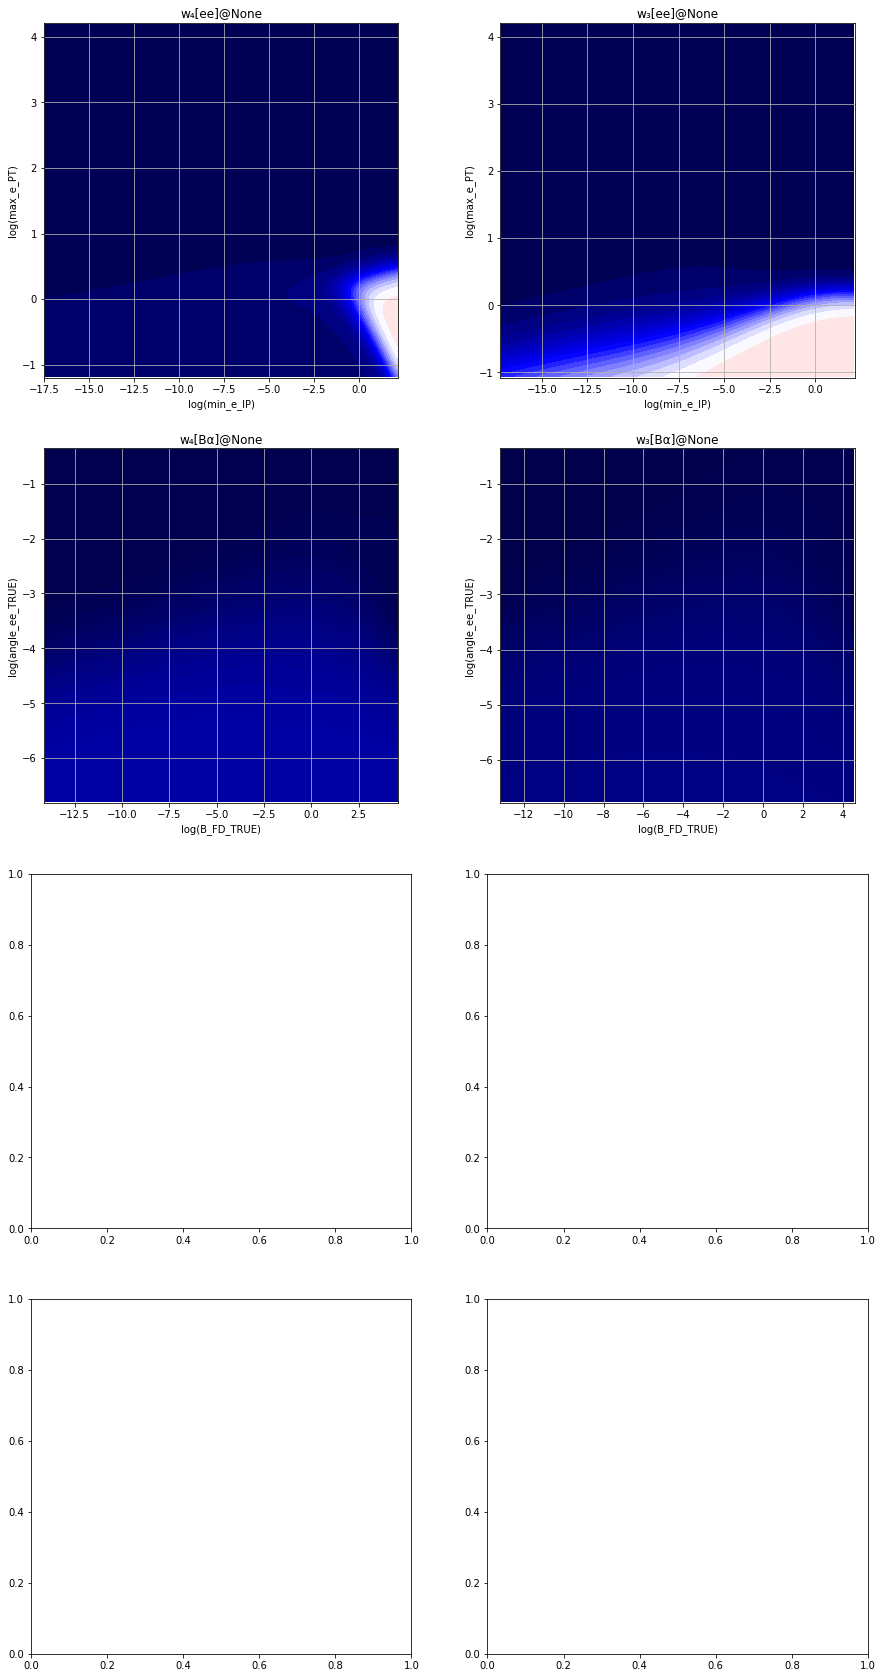

In [85]:
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
for j, ds in enumerate(all_datasets):
    ax_ = ax[j//2, j%2]
    w = results[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()

In [86]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [87]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [92]:
w_train = make_w(train_ds, results.values(), "train, w")
w_train

train, w        w₄[ee]@None w₃[ee]@None w₄[Bα]@None w₃[Bα]@None w₄[4]@None  \
B⁺→K⁺ee            0.046074    0.055882    0.029718     0.02635       0.09   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02        0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)    0.013289    0.015608    0.018076    0.018655   0.016041   
D⁺→π⁺φ(→ee)            0.07    0.246486    0.028947    0.026199       0.07   

train, w        w₃[4]@None  
B⁺→K⁺ee           0.151265  
B⁺→K⁺J/ψ(→ee)         0.02  
B⁺→K⁺ψ(2S)(→ee)    0.01457  
D⁺→π⁺φ(→ee)       0.486724

In [93]:
w_test = make_w(test_ds, results.values(), "test, w")
w_test

test, w         w₄[ee]@None w₃[ee]@None w₄[Bα]@None w₃[Bα]@None w₄[4]@None  \
B⁺→K⁺ee            0.045875     0.05533    0.029589    0.026285   0.089603   
B⁺→K⁺J/ψ(→ee)      0.020125     0.02005    0.020011        0.02   0.020064   
B⁺→K⁺ψ(2S)(→ee)    0.013287    0.015581    0.018092    0.018674   0.016058   
D⁺→π⁺φ(→ee)        0.070139    0.247037    0.028969     0.02621   0.070253   

test, w         w₃[4]@None  
B⁺→K⁺ee           0.149348  
B⁺→K⁺J/ψ(→ee)     0.020012  
B⁺→K⁺ψ(2S)(→ee)   0.014563  
D⁺→π⁺φ(→ee)       0.488904

In [94]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[ee]@None w₃[ee]@None w₄[Bα]@None w₃[Bα]@None w₄[4]@None  \
B⁺→K⁺ee             2.733329    3.800612    1.001546    0.652161   7.692284   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0         0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.680145   -0.446176   -0.195918   -0.137031  -0.402366   
D⁺→π⁺φ(→ee)         5.376343   30.057256     0.92141    0.636561   5.376345   

train, (R-1)*100 w₃[4]@None  
B⁺→K⁺ee           15.466015  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.551061  
D⁺→π⁺φ(→ee)       90.930336

In [95]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[ee]@None w₃[ee]@None w₄[Bα]@None w₃[Bα]@None w₄[4]@None  \
B⁺→K⁺ee            2.698874    3.734626    0.986964    0.645524   7.638227   
B⁺→K⁺J/ψ(→ee)           0.0         0.0         0.0         0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.692923   -0.453995   -0.195432   -0.135125  -0.407179   
D⁺→π⁺φ(→ee)        5.378671    30.14577    0.922441    0.637798   5.398112   

test, (R-1)*100 w₃[4]@None  
B⁺→K⁺ee          15.204263  
B⁺→K⁺J/ψ(→ee)          0.0  
B⁺→K⁺ψ(2S)(→ee)  -0.553026  
D⁺→π⁺φ(→ee)       91.74227

In [96]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [97]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [98]:
map_all(compute_L, results, "L", dtype=float)

w₄[ee]@None    0.727937
w₃[ee]@None    0.593072
w₄[Bα]@None    0.071524
w₃[Bα]@None    0.030421
w₄[4]@None     2.688549
w₃[4]@None     4.227583
Name: L, dtype: float64

### L

In [99]:
%%time
L_results = dict()
for target_L in [0.05, 0.07, 0.10, 0.5, 1.0, None]:
    ds = all_datasets[4]
    est = all_est[4]
    name = "w%s@%s"%(ds.name, target_L)
    w = w_from_est(est, name=name)
    w.train(ds, target_L=target_L)
    L_results[target_L] = w

Epoch 0 loss=-4.000020 W+c=[  5.8899 -10.2373   6.2672  -0.8936] det=0.000002 L=0.183070
Epoch 1 loss=-4.000022 W+c=[  5.8925 -10.1973   6.2079  -0.8941] det=0.000002 L=0.183236
Epoch 2 loss=-4.000023 W+c=[  5.895  -10.1576   6.1497  -0.8946] det=0.000002 L=0.183398
Epoch 3 loss=-4.000021 W+c=[  5.8974 -10.1183   6.0926  -0.8951] det=0.000002 L=0.183557
Epoch 4 loss=-4.000022 W+c=[  5.8998 -10.0795   6.0366  -0.8956] det=0.000002 L=0.183713
Epoch 5 loss=-4.000023 W+c=[  5.9022 -10.041    5.9816  -0.8961] det=0.000002 L=0.183865
Epoch 6 loss=-4.000020 W+c=[  5.9046 -10.0029   5.9277  -0.8967] det=0.000002 L=0.184015
Epoch 7 loss=-4.000021 W+c=[ 5.9069 -9.9652  5.8747 -0.8972] det=0.000002 L=0.184161
Epoch 8 loss=-4.000018 W+c=[ 5.9092 -9.9278  5.8227 -0.8977] det=0.000002 L=0.184304
Epoch 9 loss=-4.000021 W+c=[ 5.9114 -9.8908  5.7717 -0.8983] det=0.000002 L=0.184444
Epoch 10 loss=-4.000019 W+c=[ 5.9136 -9.8541  5.7215 -0.8988] det=0.000002 L=0.184580
Epoch 11 loss=-4.000023 W+c=[ 5.9158

Epoch 96 loss=-4.000027 W+c=[ 5.9959 -7.5678  3.3447 -0.9505] det=0.000004 L=0.207303
Epoch 97 loss=-4.000028 W+c=[ 5.9959 -7.5482  3.3296 -0.9511] det=0.000004 L=0.207880
Epoch 98 loss=-4.000029 W+c=[ 5.9959 -7.5287  3.3147 -0.9517] det=0.000004 L=0.208454
Epoch 99 loss=-4.000031 W+c=[ 5.9959 -7.5093  3.3    -0.9522] det=0.000004 L=0.209026
Epoch 100 loss=-4.000030 W+c=[ 5.9959 -7.49    3.2854 -0.9528] det=0.000004 L=0.209595
Epoch 101 loss=-4.000029 W+c=[ 5.9958 -7.4708  3.271  -0.9534] det=0.000004 L=0.210160
Epoch 102 loss=-4.000030 W+c=[ 5.9958 -7.4518  3.2567 -0.954 ] det=0.000004 L=0.210723
Epoch 103 loss=-4.000031 W+c=[ 5.9957 -7.4329  3.2425 -0.9545] det=0.000004 L=0.211283
Epoch 104 loss=-4.000029 W+c=[ 5.9956 -7.414   3.2286 -0.9551] det=0.000004 L=0.211841
Epoch 105 loss=-4.000030 W+c=[ 5.9955 -7.3953  3.2147 -0.9557] det=0.000004 L=0.212396
Epoch 106 loss=-4.000029 W+c=[ 5.9954 -7.3767  3.201  -0.9562] det=0.000004 L=0.212947
Epoch 107 loss=-4.000032 W+c=[ 5.9952 -7.3582  

Epoch 191 loss=-4.000036 W+c=[ 5.9468 -6.114   2.3923 -0.9967] det=0.000006 L=0.251288
Epoch 192 loss=-4.000036 W+c=[ 5.9459 -6.1022  2.3856 -0.9971] det=0.000006 L=0.251655
Epoch 193 loss=-4.000038 W+c=[ 5.945  -6.0905  2.379  -0.9974] det=0.000006 L=0.252019
Epoch 194 loss=-4.000037 W+c=[ 5.9441 -6.0788  2.3725 -0.9978] det=0.000006 L=0.252382
Epoch 195 loss=-4.000036 W+c=[ 5.9432 -6.0671  2.366  -0.9982] det=0.000006 L=0.252743
Epoch 196 loss=-4.000038 W+c=[ 5.9423 -6.0556  2.3596 -0.9985] det=0.000006 L=0.253103
Epoch 197 loss=-4.000038 W+c=[ 5.9414 -6.044   2.3532 -0.9989] det=0.000006 L=0.253461
Epoch 198 loss=-4.000036 W+c=[ 5.9405 -6.0326  2.3468 -0.9993] det=0.000006 L=0.253818
Epoch 199 loss=-4.000036 W+c=[ 5.9396 -6.0212  2.3405 -0.9996] det=0.000006 L=0.254172
W= [[0.3454 0.1721 0.1373 0.1882]
 [0.2462 0.332  0.3271 0.1   ]
 [0.251  0.4406 0.5056 0.0584]
 [0.1574 0.0553 0.0299 0.6533]]
W+= [[  5.9386  -6.0098   2.3342  -1.    ]
 [ -9.4382  32.1879 -18.227   -0.5772]
 [  5.3

Epoch 83 loss=-3.310632 W+c=[37.8732 -2.3176  0.9843 -0.5715] det=0.000000 L=1.465680
Epoch 84 loss=-3.324783 W+c=[38.0876 -2.3186  0.9776 -0.5707] det=0.000000 L=1.474710
Epoch 85 loss=-3.338817 W+c=[38.2939 -2.3195  0.9709 -0.5699] det=0.000000 L=1.483218
Epoch 86 loss=-3.352725 W+c=[38.4923 -2.3205  0.9644 -0.5691] det=0.000000 L=1.491214
Epoch 87 loss=-3.366527 W+c=[38.6828 -2.3215  0.9579 -0.5683] det=0.000000 L=1.498708
Epoch 88 loss=-3.380218 W+c=[38.8656 -2.3225  0.9514 -0.5675] det=0.000000 L=1.505715
Epoch 89 loss=-3.393800 W+c=[39.0408 -2.3235  0.945  -0.5666] det=0.000000 L=1.512244
Epoch 90 loss=-3.407277 W+c=[39.2084 -2.3245  0.9387 -0.5658] det=0.000000 L=1.518311
Epoch 91 loss=-3.420654 W+c=[39.3686 -2.3255  0.9325 -0.565 ] det=0.000000 L=1.523923
Epoch 92 loss=-3.433923 W+c=[39.5215 -2.3265  0.9263 -0.5642] det=0.000000 L=1.529089
Epoch 93 loss=-3.447093 W+c=[39.6672 -2.3276  0.9201 -0.5634] det=0.000000 L=1.533831
Epoch 94 loss=-3.460161 W+c=[39.8058 -2.3286  0.9141 -

Epoch 178 loss=-4.380894 W+c=[36.7441 -2.3457  0.5676 -0.4683] det=0.000001 L=1.207019
Epoch 179 loss=-4.390903 W+c=[36.6286 -2.3447  0.5648 -0.467 ] det=0.000001 L=1.202756
Epoch 180 loss=-4.400910 W+c=[36.5126 -2.3438  0.5621 -0.4656] det=0.000001 L=1.198485
Epoch 181 loss=-4.410895 W+c=[36.3964 -2.3428  0.5594 -0.4642] det=0.000001 L=1.194218
Epoch 182 loss=-4.420878 W+c=[36.2799 -2.3418  0.5567 -0.4628] det=0.000001 L=1.189946
Epoch 183 loss=-4.430834 W+c=[36.1631 -2.3407  0.554  -0.4615] det=0.000001 L=1.185677
Epoch 184 loss=-4.440801 W+c=[36.0461 -2.3397  0.5513 -0.4601] det=0.000001 L=1.181405
Epoch 185 loss=-4.450748 W+c=[35.9289 -2.3386  0.5487 -0.4587] det=0.000001 L=1.177137
Epoch 186 loss=-4.460679 W+c=[35.8115 -2.3375  0.546  -0.4573] det=0.000001 L=1.172872
Epoch 187 loss=-4.470600 W+c=[35.694  -2.3363  0.5434 -0.4559] det=0.000001 L=1.168605
Epoch 188 loss=-4.480514 W+c=[35.5763 -2.3352  0.5408 -0.4545] det=0.000001 L=1.164343
Epoch 189 loss=-4.490418 W+c=[35.4586 -2.33

Epoch 273 loss=-5.247031 W+c=[26.8635 -2.162   0.3587 -0.3243] det=0.000001 L=0.867011
Epoch 274 loss=-5.254512 W+c=[26.7872 -2.1594  0.3568 -0.3227] det=0.000001 L=0.864899
Epoch 275 loss=-5.261923 W+c=[26.7116 -2.1567  0.3548 -0.321 ] det=0.000001 L=0.862807
Epoch 276 loss=-5.269292 W+c=[26.6367 -2.1541  0.3529 -0.3194] det=0.000001 L=0.860732
Epoch 277 loss=-5.276599 W+c=[26.5626 -2.1514  0.351  -0.3177] det=0.000001 L=0.858675
Epoch 278 loss=-5.283864 W+c=[26.4892 -2.1488  0.349  -0.3161] det=0.000001 L=0.856636
Epoch 279 loss=-5.291062 W+c=[26.4165 -2.1461  0.3471 -0.3144] det=0.000001 L=0.854618
Epoch 280 loss=-5.298197 W+c=[26.3445 -2.1434  0.3451 -0.3128] det=0.000001 L=0.852617
Epoch 281 loss=-5.305277 W+c=[26.2732 -2.1407  0.3432 -0.3111] det=0.000001 L=0.850635
Epoch 282 loss=-5.312298 W+c=[26.2026 -2.138   0.3413 -0.3094] det=0.000001 L=0.848674
Epoch 283 loss=-5.319273 W+c=[26.1328 -2.1354  0.3393 -0.3078] det=0.000001 L=0.846729
Epoch 284 loss=-5.326171 W+c=[26.0637 -2.13

Epoch 368 loss=-5.646103 W+c=[22.6484 -1.9086  0.1626 -0.1595] det=0.000002 L=0.747355
Epoch 369 loss=-5.646626 W+c=[22.6331 -1.9062  0.1604 -0.1578] det=0.000002 L=0.746839
Epoch 370 loss=-5.647073 W+c=[22.6184 -1.9038  0.1581 -0.156 ] det=0.000002 L=0.746333
Epoch 371 loss=-5.647460 W+c=[22.6041 -1.9014  0.1559 -0.1542] det=0.000002 L=0.745839
Epoch 372 loss=-5.647758 W+c=[22.5903 -1.899   0.1536 -0.1524] det=0.000002 L=0.745355
Epoch 373 loss=-5.648008 W+c=[22.5771 -1.8966  0.1513 -0.1506] det=0.000002 L=0.744878
Epoch 374 loss=-5.648173 W+c=[22.5643 -1.8942  0.149  -0.1487] det=0.000002 L=0.744412
Epoch 375 loss=-5.648257 W+c=[22.5521 -1.8918  0.1468 -0.1469] det=0.000002 L=0.743958
Epoch 376 loss=-5.648286 W+c=[22.5403 -1.8895  0.1445 -0.1451] det=0.000002 L=0.743511
Epoch 377 loss=-5.648243 W+c=[22.529  -1.8871  0.1422 -0.1433] det=0.000002 L=0.743075
Epoch 378 loss=-5.648137 W+c=[22.5182 -1.8848  0.1399 -0.1415] det=0.000002 L=0.742647
Epoch 379 loss=-5.647954 W+c=[22.5079 -1.88

Epoch 463 loss=-5.164231 W+c=[23.641  -1.6402  0.0506 -0.0104] det=0.000001 L=0.849353
Epoch 464 loss=-5.159717 W+c=[23.7015 -1.6403  0.0469 -0.0085] det=0.000001 L=0.850898
Epoch 465 loss=-5.155296 W+c=[23.7613 -1.6404  0.0432 -0.0065] det=0.000001 L=0.852395
Epoch 466 loss=-5.151001 W+c=[23.8204 -1.6405  0.0396 -0.0046] det=0.000001 L=0.853842
Epoch 467 loss=-5.146829 W+c=[23.8788 -1.6406  0.036  -0.0027] det=0.000001 L=0.855241
Epoch 468 loss=-5.142767 W+c=[23.9365 -1.6407  0.0324 -0.0009] det=0.000001 L=0.856591
Epoch 469 loss=-4.188516 W+c=[23.9935 -1.6408  0.0288  0.001 ] det=0.000001 L=0.857897
Epoch 470 loss=-4.194794 W+c=[24.0489 -1.6432  0.0269  0.0004] det=0.000001 L=0.858662
Epoch 471 loss=-5.140635 W+c=[24.1033 -1.6457  0.0251 -0.0001] det=0.000001 L=0.859408
Epoch 472 loss=-4.199342 W+c=[24.1575 -1.6457  0.0217  0.0017] det=0.000001 L=0.860601
Epoch 473 loss=-4.205423 W+c=[24.2108 -1.6482  0.02    0.0011] det=0.000001 L=0.861295
Epoch 474 loss=-4.211388 W+c=[24.2632 -1.65

Epoch 54 loss=-4.000026 W+c=[ 5.9787 -8.5117  4.1637 -0.925 ] det=0.000003 L=0.187689
Epoch 55 loss=-4.000027 W+c=[ 5.9796 -8.4861  4.1387 -0.9257] det=0.000003 L=0.187700
Epoch 56 loss=-4.000026 W+c=[ 5.9804 -8.4607  4.1142 -0.9263] det=0.000003 L=0.187709
Epoch 57 loss=-4.000025 W+c=[ 5.9812 -8.4354  4.0899 -0.9269] det=0.000003 L=0.187716
Epoch 58 loss=-4.000029 W+c=[ 5.982  -8.4103  4.066  -0.9275] det=0.000003 L=0.187818
Epoch 59 loss=-4.000028 W+c=[ 5.9827 -8.3854  4.0424 -0.9281] det=0.000003 L=0.188377
Epoch 60 loss=-4.000028 W+c=[ 5.9835 -8.3606  4.0191 -0.9287] det=0.000003 L=0.188932
Epoch 61 loss=-4.000026 W+c=[ 5.9842 -8.336   3.9961 -0.9294] det=0.000003 L=0.189484
Epoch 62 loss=-4.000025 W+c=[ 5.9848 -8.3116  3.9734 -0.93  ] det=0.000003 L=0.190033
Epoch 63 loss=-4.000026 W+c=[ 5.9855 -8.2874  3.9509 -0.9306] det=0.000003 L=0.190578
Epoch 64 loss=-4.000027 W+c=[ 5.9861 -8.2633  3.9288 -0.9312] det=0.000003 L=0.191120
Epoch 65 loss=-4.000028 W+c=[ 5.9868 -8.2393  3.9069 -

Epoch 149 loss=-4.000034 W+c=[ 5.9787 -6.6674  2.7202 -0.9788] det=0.000005 L=0.234287
Epoch 150 loss=-4.000031 W+c=[ 5.9781 -6.6528  2.7111 -0.9792] det=0.000005 L=0.234732
Epoch 151 loss=-4.000033 W+c=[ 5.9775 -6.6383  2.702  -0.9797] det=0.000005 L=0.235175
Epoch 152 loss=-4.000034 W+c=[ 5.9768 -6.6238  2.693  -0.9802] det=0.000005 L=0.235616
Epoch 153 loss=-4.000035 W+c=[ 5.9762 -6.6094  2.6841 -0.9807] det=0.000005 L=0.236055
Epoch 154 loss=-4.000032 W+c=[ 5.9755 -6.5951  2.6753 -0.9811] det=0.000005 L=0.236491
Epoch 155 loss=-4.000033 W+c=[ 5.9749 -6.5809  2.6665 -0.9816] det=0.000005 L=0.236925
Epoch 156 loss=-4.000033 W+c=[ 5.9742 -6.5667  2.6578 -0.9821] det=0.000005 L=0.237358
Epoch 157 loss=-4.000031 W+c=[ 5.9736 -6.5526  2.6492 -0.9825] det=0.000005 L=0.237788
Epoch 158 loss=-4.000033 W+c=[ 5.9729 -6.5387  2.6406 -0.983 ] det=0.000005 L=0.238216
Epoch 159 loss=-4.000036 W+c=[ 5.9722 -6.5247  2.6322 -0.9834] det=0.000005 L=0.238643
Epoch 160 loss=-4.000035 W+c=[ 5.9715 -6.51

Epoch 40 loss=-4.894650 W+c=[15.9762 -2.1353  1.5172 -0.6437] det=0.000002 L=1.067096
Epoch 41 loss=-4.839459 W+c=[16.2379 -2.1263  1.5022 -0.6392] det=0.000002 L=1.081862
Epoch 42 loss=-4.787549 W+c=[16.4993 -2.1179  1.4875 -0.6348] det=0.000002 L=1.095165
Epoch 43 loss=-4.738686 W+c=[16.7605 -2.1099  1.473  -0.6306] det=0.000002 L=1.107045
Epoch 44 loss=-4.692718 W+c=[17.0213 -2.1024  1.4587 -0.6266] det=0.000002 L=1.120424
Epoch 45 loss=-4.649459 W+c=[17.2819 -2.0952  1.4446 -0.6226] det=0.000002 L=1.135208
Epoch 46 loss=-4.608810 W+c=[17.5422 -2.0885  1.4308 -0.6188] det=0.000002 L=1.148806
Epoch 47 loss=-4.570551 W+c=[17.8022 -2.0821  1.4172 -0.6152] det=0.000002 L=1.161248
Epoch 48 loss=-4.534603 W+c=[18.062  -2.076   1.4039 -0.6116] det=0.000002 L=1.172555
Epoch 49 loss=-4.500831 W+c=[18.3214 -2.0702  1.3907 -0.6082] det=0.000002 L=1.182751
Epoch 50 loss=-4.469111 W+c=[18.5806 -2.0647  1.3778 -0.6048] det=0.000002 L=1.191867
Epoch 51 loss=-4.439335 W+c=[18.8395 -2.0595  1.3651 -

Epoch 135 loss=-4.351515 W+c=[33.1166 -1.9571  0.7602 -0.467 ] det=0.000001 L=1.567054
Epoch 136 loss=-4.357341 W+c=[33.156  -1.9569  0.756  -0.4659] det=0.000001 L=1.566099
Epoch 137 loss=-4.363198 W+c=[33.1927 -1.9567  0.7518 -0.4648] det=0.000001 L=1.565044
Epoch 138 loss=-4.369064 W+c=[33.2269 -1.9565  0.7477 -0.4636] det=0.000001 L=1.563895
Epoch 139 loss=-4.374971 W+c=[33.2584 -1.9563  0.7436 -0.4625] det=0.000001 L=1.562653
Epoch 140 loss=-4.380896 W+c=[33.2874 -1.9561  0.7395 -0.4614] det=0.000001 L=1.561322
Epoch 141 loss=-4.386839 W+c=[33.3139 -1.9559  0.7354 -0.4603] det=0.000001 L=1.559911
Epoch 142 loss=-4.392801 W+c=[33.338  -1.9556  0.7314 -0.4592] det=0.000001 L=1.558415
Epoch 143 loss=-4.398785 W+c=[33.3597 -1.9554  0.7275 -0.4581] det=0.000001 L=1.556844
Epoch 144 loss=-4.404783 W+c=[33.379  -1.9552  0.7235 -0.457 ] det=0.000001 L=1.555202
Epoch 145 loss=-4.410802 W+c=[33.396  -1.9549  0.7196 -0.4559] det=0.000001 L=1.553483
Epoch 146 loss=-4.416843 W+c=[33.4106 -1.95

Epoch 230 loss=-4.959390 W+c=[29.9789 -1.8938  0.4799 -0.3578] det=0.000001 L=1.311951
Epoch 231 loss=-4.965943 W+c=[29.9141 -1.8925  0.4778 -0.3566] det=0.000001 L=1.308956
Epoch 232 loss=-4.972509 W+c=[29.8493 -1.8913  0.4757 -0.3553] det=0.000001 L=1.305966
Epoch 233 loss=-4.979064 W+c=[29.7845 -1.8901  0.4736 -0.3541] det=0.000001 L=1.302983
Epoch 234 loss=-4.985610 W+c=[29.7196 -1.8888  0.4715 -0.3529] det=0.000001 L=1.300013
Epoch 235 loss=-4.992146 W+c=[29.6548 -1.8876  0.4695 -0.3516] det=0.000001 L=1.297050
Epoch 236 loss=-4.998679 W+c=[29.5899 -1.8863  0.4674 -0.3504] det=0.000001 L=1.294096
Epoch 237 loss=-5.005205 W+c=[29.5251 -1.885   0.4654 -0.3491] det=0.000001 L=1.291149
Epoch 238 loss=-5.011722 W+c=[29.4603 -1.8837  0.4633 -0.3479] det=0.000001 L=1.288213
Epoch 239 loss=-5.018225 W+c=[29.3956 -1.8824  0.4613 -0.3466] det=0.000001 L=1.285286
Epoch 240 loss=-5.024720 W+c=[29.3309 -1.8811  0.4593 -0.3454] det=0.000001 L=1.282371
Epoch 241 loss=-5.031209 W+c=[29.2662 -1.87

Epoch 325 loss=-5.498710 W+c=[24.7266 -1.7448  0.3035 -0.2314] det=0.000002 L=1.085446
Epoch 326 loss=-5.502843 W+c=[24.6878 -1.7431  0.3017 -0.2299] det=0.000002 L=1.083839
Epoch 327 loss=-5.506938 W+c=[24.6493 -1.7413  0.2999 -0.2285] det=0.000002 L=1.082249
Epoch 328 loss=-5.510996 W+c=[24.6113 -1.7395  0.2982 -0.2271] det=0.000002 L=1.080673
Epoch 329 loss=-5.515005 W+c=[24.5736 -1.7378  0.2964 -0.2256] det=0.000002 L=1.079116
Epoch 330 loss=-5.518967 W+c=[24.5364 -1.736   0.2946 -0.2242] det=0.000002 L=1.077578
Epoch 331 loss=-5.522888 W+c=[24.4996 -1.7343  0.2928 -0.2228] det=0.000002 L=1.076054
Epoch 332 loss=-5.526755 W+c=[24.4631 -1.7325  0.291  -0.2213] det=0.000002 L=1.074551
Epoch 333 loss=-5.530581 W+c=[24.4271 -1.7307  0.2892 -0.2199] det=0.000002 L=1.073062
Epoch 334 loss=-5.534372 W+c=[24.3915 -1.729   0.2874 -0.2185] det=0.000002 L=1.071590
Epoch 335 loss=-5.538108 W+c=[24.3563 -1.7272  0.2856 -0.217 ] det=0.000002 L=1.070135
Epoch 336 loss=-5.541803 W+c=[24.3215 -1.72

Epoch 420 loss=-5.687212 W+c=[22.729  -1.5873  0.1228 -0.0883] det=0.000002 L=0.997019
Epoch 421 loss=-5.687170 W+c=[22.7239 -1.5858  0.1207 -0.0867] det=0.000002 L=0.996569
Epoch 422 loss=-5.687094 W+c=[22.7191 -1.5844  0.1187 -0.0851] det=0.000002 L=0.996126
Epoch 423 loss=-5.686989 W+c=[22.7146 -1.5829  0.1166 -0.0835] det=0.000002 L=0.995685
Epoch 424 loss=-5.686851 W+c=[22.7103 -1.5815  0.1146 -0.0819] det=0.000002 L=0.995249
Epoch 425 loss=-5.686679 W+c=[22.7062 -1.58    0.1125 -0.0803] det=0.000002 L=0.994817
Epoch 426 loss=-5.686479 W+c=[22.7025 -1.5786  0.1104 -0.0787] det=0.000002 L=0.994388
Epoch 427 loss=-5.686248 W+c=[22.699  -1.5772  0.1084 -0.0771] det=0.000002 L=0.993963
Epoch 428 loss=-5.685982 W+c=[22.6957 -1.5758  0.1063 -0.0755] det=0.000002 L=0.993544
Epoch 429 loss=-5.685690 W+c=[22.6927 -1.5743  0.1042 -0.0739] det=0.000002 L=0.993126
Epoch 430 loss=-5.685371 W+c=[22.6899 -1.5729  0.1021 -0.0723] det=0.000002 L=0.992710
Epoch 431 loss=-5.685025 W+c=[22.6874 -1.57

Epoch 11 loss=-4.000023 W+c=[ 5.9158 -9.8178  5.6723 -0.8994] det=0.000002 L=0.184714
Epoch 12 loss=-4.000020 W+c=[ 5.9179 -9.7818  5.6239 -0.8999] det=0.000002 L=0.184844
Epoch 13 loss=-4.000024 W+c=[ 5.92   -9.7462  5.5764 -0.9005] det=0.000002 L=0.184972
Epoch 14 loss=-4.000024 W+c=[ 5.922  -9.7108  5.5297 -0.901 ] det=0.000002 L=0.185096
Epoch 15 loss=-4.000023 W+c=[ 5.9241 -9.6758  5.4838 -0.9016] det=0.000002 L=0.185217
Epoch 16 loss=-4.000025 W+c=[ 5.9261 -9.6411  5.4387 -0.9022] det=0.000002 L=0.185335
Epoch 17 loss=-4.000024 W+c=[ 5.928  -9.6067  5.3944 -0.9027] det=0.000002 L=0.185449
Epoch 18 loss=-4.000022 W+c=[ 5.9299 -9.5726  5.3508 -0.9033] det=0.000002 L=0.185561
Epoch 19 loss=-4.000025 W+c=[ 5.9318 -9.5389  5.308  -0.9039] det=0.000002 L=0.185670
Epoch 20 loss=-4.000025 W+c=[ 5.9337 -9.5054  5.2658 -0.9044] det=0.000002 L=0.185775
Epoch 21 loss=-4.000024 W+c=[ 5.9355 -9.4721  5.2244 -0.905 ] det=0.000002 L=0.185878
Epoch 22 loss=-4.000025 W+c=[ 5.9373 -9.4392  5.1837 -

Epoch 107 loss=-4.000032 W+c=[ 5.9952 -7.3582  3.1874 -0.9568] det=0.000004 L=0.213497
Epoch 108 loss=-4.000031 W+c=[ 5.9951 -7.3398  3.174  -0.9574] det=0.000004 L=0.214043
Epoch 109 loss=-4.000029 W+c=[ 5.9949 -7.3215  3.1607 -0.9579] det=0.000004 L=0.214587
Epoch 110 loss=-4.000031 W+c=[ 5.9948 -7.3033  3.1476 -0.9585] det=0.000004 L=0.215128
Epoch 111 loss=-4.000028 W+c=[ 5.9946 -7.2852  3.1345 -0.9591] det=0.000004 L=0.215667
Epoch 112 loss=-4.000032 W+c=[ 5.9944 -7.2673  3.1216 -0.9596] det=0.000004 L=0.216203
Epoch 113 loss=-4.000032 W+c=[ 5.9941 -7.2494  3.1089 -0.9602] det=0.000004 L=0.216736
Epoch 114 loss=-4.000031 W+c=[ 5.9939 -7.2316  3.0962 -0.9607] det=0.000004 L=0.217267
Epoch 115 loss=-4.000031 W+c=[ 5.9937 -7.214   3.0837 -0.9613] det=0.000004 L=0.217794
Epoch 116 loss=-4.000029 W+c=[ 5.9934 -7.1964  3.0713 -0.9618] det=0.000004 L=0.218320
Epoch 117 loss=-4.000030 W+c=[ 5.9931 -7.1789  3.059  -0.9624] det=0.000004 L=0.218843
Epoch 118 loss=-4.000031 W+c=[ 5.9929 -7.16

Epoch 0 loss=-14.955525 W+c=[ 5.9386 -6.0098  2.3342 -1.    ] det=0.000006 L=0.254526
Epoch 1 loss=-14.553720 W+c=[ 6.1566 -5.4291  2.2907 -0.9883] det=0.000006 L=0.278504
Epoch 2 loss=-14.051743 W+c=[ 6.3792 -4.9574  2.2543 -0.9773] det=0.000006 L=0.299725
Epoch 3 loss=-13.587832 W+c=[ 6.6017 -4.5748  2.2241 -0.9668] det=0.000006 L=0.325251
Epoch 4 loss=-13.159049 W+c=[ 6.8228 -4.2605  2.1986 -0.9568] det=0.000006 L=0.354337
Epoch 5 loss=-12.762167 W+c=[ 7.0415 -3.9992  2.1766 -0.947 ] det=0.000006 L=0.378820
Epoch 6 loss=-12.393978 W+c=[ 7.2572 -3.7794  2.1572 -0.9374] det=0.000006 L=0.400260
Epoch 7 loss=-12.051463 W+c=[ 7.4694 -3.5927  2.1398 -0.9279] det=0.000006 L=0.433836
Epoch 8 loss=-11.731986 W+c=[ 7.678  -3.4325  2.1237 -0.9186] det=0.000006 L=0.461639
Epoch 9 loss=-11.433200 W+c=[ 7.8829 -3.2937  2.1085 -0.9094] det=0.000005 L=0.483840
Epoch 10 loss=-11.153090 W+c=[ 8.0842 -3.1725  2.0939 -0.9003] det=0.000005 L=0.502647
Epoch 11 loss=-10.889888 W+c=[ 8.2821 -3.0658  2.0797

Epoch 96 loss=-5.312219 W+c=[19.9339 -1.7101  1.0357 -0.4853] det=0.000002 L=1.456914
Epoch 97 loss=-5.300719 W+c=[20.0354 -1.7077  1.0282 -0.4832] det=0.000002 L=1.463238
Epoch 98 loss=-5.289533 W+c=[20.1364 -1.7053  1.0208 -0.481 ] det=0.000002 L=1.469307
Epoch 99 loss=-5.278666 W+c=[20.2368 -1.703   1.0136 -0.4789] det=0.000002 L=1.475122
Epoch 100 loss=-5.268113 W+c=[20.3366 -1.7008  1.0064 -0.4768] det=0.000002 L=1.480685
Epoch 101 loss=-5.309834 W+c=[20.4358 -1.6986  0.9992 -0.4748] det=0.000002 L=1.486001
Epoch 102 loss=-5.299374 W+c=[20.5342 -1.6961  0.993  -0.4727] det=0.000002 L=1.493411
Epoch 103 loss=-5.289229 W+c=[20.6319 -1.6937  0.9868 -0.4707] det=0.000002 L=1.500930
Epoch 104 loss=-5.279370 W+c=[20.7291 -1.6913  0.9806 -0.4687] det=0.000002 L=1.508198
Epoch 105 loss=-5.269797 W+c=[20.8256 -1.6889  0.9745 -0.4667] det=0.000002 L=1.515212
Epoch 106 loss=-5.260499 W+c=[20.9214 -1.6866  0.9685 -0.4647] det=0.000002 L=1.521974
Epoch 107 loss=-5.251481 W+c=[21.0166 -1.6844  

Epoch 191 loss=-5.064982 W+c=[26.0333 -1.5806  0.6051 -0.3388] det=0.000001 L=1.682536
Epoch 192 loss=-5.066551 W+c=[26.0541 -1.5798  0.6021 -0.3376] det=0.000001 L=1.682355
Epoch 193 loss=-5.068179 W+c=[26.0741 -1.579   0.5991 -0.3365] det=0.000001 L=1.682116
Epoch 194 loss=-5.069850 W+c=[26.0932 -1.5782  0.5962 -0.3353] det=0.000001 L=1.681826
Epoch 195 loss=-5.071558 W+c=[26.1115 -1.5775  0.5932 -0.3341] det=0.000001 L=1.681485
Epoch 196 loss=-5.073320 W+c=[26.129  -1.5767  0.5903 -0.3329] det=0.000001 L=1.681091
Epoch 197 loss=-5.075120 W+c=[26.1457 -1.5759  0.5874 -0.3317] det=0.000001 L=1.680648
Epoch 198 loss=-5.076963 W+c=[26.1615 -1.5751  0.5846 -0.3306] det=0.000001 L=1.680154
Epoch 199 loss=-5.078854 W+c=[26.1766 -1.5744  0.5817 -0.3294] det=0.000001 L=1.679614
Epoch 200 loss=-5.080771 W+c=[26.1909 -1.5736  0.5789 -0.3282] det=0.000001 L=1.679031
Epoch 201 loss=-5.082746 W+c=[26.2044 -1.5728  0.5761 -0.3271] det=0.000001 L=1.678399
Epoch 202 loss=-5.084745 W+c=[26.2172 -1.57

Epoch 286 loss=-5.335309 W+c=[25.406  -1.5038  0.3878 -0.2344] det=0.000002 L=1.545286
Epoch 287 loss=-5.338736 W+c=[25.3836 -1.5029  0.386  -0.2333] det=0.000002 L=1.543419
Epoch 288 loss=-5.342163 W+c=[25.3611 -1.502   0.3842 -0.2323] det=0.000002 L=1.541553
Epoch 289 loss=-5.345585 W+c=[25.3384 -1.5011  0.3824 -0.2312] det=0.000002 L=1.539689
Epoch 290 loss=-5.349005 W+c=[25.3157 -1.5001  0.3807 -0.2301] det=0.000002 L=1.537833
Epoch 291 loss=-5.352429 W+c=[25.2929 -1.4992  0.3789 -0.2291] det=0.000002 L=1.535974
Epoch 292 loss=-5.355846 W+c=[25.2699 -1.4983  0.3771 -0.228 ] det=0.000002 L=1.534119
Epoch 293 loss=-5.359269 W+c=[25.247  -1.4974  0.3753 -0.2269] det=0.000002 L=1.532267
Epoch 294 loss=-5.362688 W+c=[25.2239 -1.4965  0.3736 -0.2258] det=0.000002 L=1.530420
Epoch 295 loss=-5.366102 W+c=[25.2008 -1.4956  0.3718 -0.2248] det=0.000002 L=1.528574
Epoch 296 loss=-5.369512 W+c=[25.1775 -1.4946  0.37   -0.2237] det=0.000002 L=1.526733
Epoch 297 loss=-5.372928 W+c=[25.1543 -1.49

Epoch 381 loss=-5.626192 W+c=[23.3362 -1.4113  0.2314 -0.1294] det=0.000002 L=1.393709
Epoch 382 loss=-5.628604 W+c=[23.319  -1.4103  0.2298 -0.1282] det=0.000002 L=1.392489
Epoch 383 loss=-5.630996 W+c=[23.3019 -1.4093  0.2283 -0.127 ] det=0.000002 L=1.391276
Epoch 384 loss=-5.633372 W+c=[23.285  -1.4083  0.2267 -0.1259] det=0.000002 L=1.390074
Epoch 385 loss=-5.635736 W+c=[23.2682 -1.4073  0.2251 -0.1247] det=0.000002 L=1.388878
Epoch 386 loss=-5.638072 W+c=[23.2516 -1.4063  0.2235 -0.1235] det=0.000002 L=1.387693
Epoch 387 loss=-5.640405 W+c=[23.2351 -1.4053  0.2219 -0.1223] det=0.000002 L=1.386512
Epoch 388 loss=-5.642712 W+c=[23.2188 -1.4043  0.2203 -0.1212] det=0.000002 L=1.385343
Epoch 389 loss=-5.645001 W+c=[23.2026 -1.4033  0.2187 -0.12  ] det=0.000002 L=1.384180
Epoch 390 loss=-5.647284 W+c=[23.1865 -1.4023  0.2171 -0.1188] det=0.000002 L=1.383027
Epoch 391 loss=-5.649543 W+c=[23.1706 -1.4013  0.2155 -0.1176] det=0.000002 L=1.381878
Epoch 392 loss=-5.651787 W+c=[23.1548 -1.40

Epoch 476 loss=-5.793008 W+c=[22.3151 -1.3207  0.0738 -0.006 ] det=0.000002 L=1.306620
Epoch 477 loss=-5.794415 W+c=[22.3099 -1.3198  0.072  -0.0045] det=0.000002 L=1.305880
Epoch 478 loss=-5.795835 W+c=[22.3048 -1.3189  0.0702 -0.003 ] det=0.000002 L=1.305135
Epoch 479 loss=-5.797261 W+c=[22.2998 -1.318   0.0684 -0.0015] det=0.000002 L=1.304393
Epoch 480 loss=-5.798681 W+c=[22.2949 -1.3172  0.0666 -0.    ] det=0.000002 L=1.303650
Epoch 481 loss=-4.722436 W+c=[22.2901 -1.3163  0.0648  0.0015] det=0.000002 L=1.302907
Epoch 482 loss=-4.723686 W+c=[22.2889 -1.3171  0.0639  0.001 ] det=0.000002 L=1.303050
Epoch 483 loss=-4.724883 W+c=[22.2879 -1.318   0.0631  0.0006] det=0.000002 L=1.303206
Epoch 484 loss=-4.726020 W+c=[22.2871 -1.3188  0.0622  0.0001] det=0.000003 L=1.303371
Epoch 485 loss=-5.800896 W+c=[22.2866 -1.3196  0.0614 -0.0004] det=0.000003 L=1.303549
Epoch 486 loss=-4.725819 W+c=[22.283  -1.3186  0.0596  0.0012] det=0.000003 L=1.302862
Epoch 487 loss=-4.726885 W+c=[22.2827 -1.31

Epoch 67 loss=-4.000025 W+c=[ 5.9879 -8.1919  3.8641 -0.9331] det=0.000003 L=0.192727
Epoch 68 loss=-4.000026 W+c=[ 5.9885 -8.1684  3.843  -0.9337] det=0.000003 L=0.193257
Epoch 69 loss=-4.000026 W+c=[ 5.989  -8.1451  3.8222 -0.9343] det=0.000003 L=0.193783
Epoch 70 loss=-4.000027 W+c=[ 5.9895 -8.1219  3.8017 -0.9349] det=0.000003 L=0.194306
Epoch 71 loss=-4.000029 W+c=[ 5.99   -8.0989  3.7814 -0.9355] det=0.000003 L=0.194826
Epoch 72 loss=-4.000027 W+c=[ 5.9905 -8.076   3.7614 -0.9361] det=0.000003 L=0.195343
Epoch 73 loss=-4.000028 W+c=[ 5.9909 -8.0533  3.7416 -0.9367] det=0.000003 L=0.195856
Epoch 74 loss=-4.000027 W+c=[ 5.9913 -8.0307  3.7221 -0.9373] det=0.000003 L=0.196366
Epoch 75 loss=-4.000027 W+c=[ 5.9917 -8.0083  3.7027 -0.938 ] det=0.000003 L=0.196874
Epoch 76 loss=-4.000028 W+c=[ 5.9921 -7.986   3.6837 -0.9386] det=0.000003 L=0.197378
Epoch 77 loss=-4.000028 W+c=[ 5.9925 -7.9638  3.6648 -0.9392] det=0.000003 L=0.197880
Epoch 78 loss=-4.000029 W+c=[ 5.9928 -7.9418  3.6461 -

Epoch 162 loss=-4.000035 W+c=[ 5.9701 -6.4833  2.6071 -0.9848] det=0.000005 L=0.239910
Epoch 163 loss=-4.000033 W+c=[ 5.9694 -6.4697  2.5989 -0.9852] det=0.000005 L=0.240328
Epoch 164 loss=-4.000035 W+c=[ 5.9687 -6.4561  2.5907 -0.9857] det=0.000005 L=0.240745
Epoch 165 loss=-4.000034 W+c=[ 5.9679 -6.4425  2.5826 -0.9861] det=0.000005 L=0.241159
Epoch 166 loss=-4.000035 W+c=[ 5.9672 -6.4291  2.5746 -0.9865] det=0.000005 L=0.241571
Epoch 167 loss=-4.000033 W+c=[ 5.9665 -6.4157  2.5666 -0.987 ] det=0.000005 L=0.241982
Epoch 168 loss=-4.000034 W+c=[ 5.9657 -6.4024  2.5587 -0.9874] det=0.000005 L=0.242390
Epoch 169 loss=-4.000032 W+c=[ 5.965  -6.3892  2.5509 -0.9878] det=0.000005 L=0.242797
Epoch 170 loss=-4.000037 W+c=[ 5.9642 -6.376   2.5431 -0.9883] det=0.000005 L=0.243203
Epoch 171 loss=-4.000035 W+c=[ 5.9634 -6.3629  2.5354 -0.9887] det=0.000005 L=0.243605
Epoch 172 loss=-4.000034 W+c=[ 5.9627 -6.3498  2.5277 -0.9891] det=0.000005 L=0.244006
Epoch 173 loss=-4.000035 W+c=[ 5.9619 -6.33

Epoch 53 loss=-9.371602 W+c=[11.4562 -1.762   1.6623 -0.6686] det=0.000004 L=1.040124
Epoch 54 loss=-9.357212 W+c=[11.4824 -1.7513  1.6512 -0.6642] det=0.000004 L=1.046727
Epoch 55 loss=-9.343446 W+c=[11.5075 -1.7408  1.6403 -0.6598] det=0.000004 L=1.053200
Epoch 56 loss=-9.330271 W+c=[11.5314 -1.7305  1.6295 -0.6555] det=0.000004 L=1.059547
Epoch 57 loss=-9.317648 W+c=[11.5541 -1.7205  1.6187 -0.6512] det=0.000004 L=1.065778
Epoch 58 loss=-9.305555 W+c=[11.5758 -1.7107  1.608  -0.647 ] det=0.000004 L=1.071900
Epoch 59 loss=-9.293960 W+c=[11.5965 -1.7011  1.5974 -0.6427] det=0.000004 L=1.077918
Epoch 60 loss=-9.282843 W+c=[11.6162 -1.6917  1.5869 -0.6386] det=0.000004 L=1.083836
Epoch 61 loss=-9.272178 W+c=[11.635  -1.6824  1.5764 -0.6344] det=0.000004 L=1.089661
Epoch 62 loss=-9.261933 W+c=[11.6529 -1.6734  1.5661 -0.6303] det=0.000004 L=1.095396
Epoch 63 loss=-9.252102 W+c=[11.6699 -1.6645  1.5558 -0.6262] det=0.000004 L=1.101048
Epoch 64 loss=-9.242649 W+c=[11.686  -1.6558  1.5457 -

Epoch 148 loss=-9.034332 W+c=[11.9879 -1.2005  0.9668 -0.3632] det=0.000005 L=1.459470
Epoch 149 loss=-9.031289 W+c=[11.9899 -1.1966  0.9632 -0.3607] det=0.000005 L=1.463361
Epoch 150 loss=-9.028299 W+c=[11.9918 -1.1927  0.9596 -0.3582] det=0.000005 L=1.467225
Epoch 151 loss=-9.025354 W+c=[11.9935 -1.1888  0.956  -0.3558] det=0.000005 L=1.471062
Epoch 152 loss=-9.022441 W+c=[11.9952 -1.185   0.9524 -0.3533] det=0.000005 L=1.474878
Epoch 153 loss=-9.019575 W+c=[11.9967 -1.1812  0.9487 -0.3509] det=0.000005 L=1.478669
Epoch 154 loss=-9.016742 W+c=[11.9982 -1.1774  0.9451 -0.3485] det=0.000005 L=1.482438
Epoch 155 loss=-9.013939 W+c=[11.9996 -1.1737  0.9415 -0.3461] det=0.000005 L=1.486185
Epoch 156 loss=-9.011166 W+c=[12.0008 -1.17    0.9378 -0.3437] det=0.000005 L=1.489911
Epoch 157 loss=-9.008425 W+c=[12.002  -1.1664  0.9342 -0.3414] det=0.000005 L=1.493619
Epoch 158 loss=-9.005704 W+c=[12.0032 -1.1628  0.9306 -0.339 ] det=0.000005 L=1.497309
Epoch 159 loss=-9.003007 W+c=[12.0043 -1.15

Epoch 243 loss=-8.784528 W+c=[12.1194 -0.9349  0.6431 -0.1715] det=0.000006 L=1.778385
Epoch 244 loss=-8.781969 W+c=[12.122  -0.9329  0.64   -0.1698] det=0.000006 L=1.781416
Epoch 245 loss=-8.779430 W+c=[12.1247 -0.9309  0.637  -0.1682] det=0.000006 L=1.784442
Epoch 246 loss=-8.776887 W+c=[12.1273 -0.9289  0.634  -0.1665] det=0.000006 L=1.787459
Epoch 247 loss=-8.774362 W+c=[12.13   -0.9269  0.6309 -0.1648] det=0.000006 L=1.790469
Epoch 248 loss=-8.771849 W+c=[12.1328 -0.9249  0.6279 -0.1631] det=0.000006 L=1.793466
Epoch 249 loss=-8.769348 W+c=[12.1355 -0.9229  0.6249 -0.1614] det=0.000006 L=1.796456
Epoch 250 loss=-8.766856 W+c=[12.1383 -0.921   0.6219 -0.1597] det=0.000006 L=1.799438
Epoch 251 loss=-8.764377 W+c=[12.1412 -0.919   0.6189 -0.1581] det=0.000006 L=1.802412
Epoch 252 loss=-8.761913 W+c=[12.144  -0.9171  0.6159 -0.1564] det=0.000006 L=1.805373
Epoch 253 loss=-8.759460 W+c=[12.1469 -0.9152  0.6129 -0.1547] det=0.000006 L=1.808328
Epoch 254 loss=-8.757027 W+c=[12.1498 -0.91

Epoch 338 loss=-8.711243 W+c=[12.4915 -0.7816  0.3786 -0.012 ] det=0.000007 L=2.055987
Epoch 339 loss=-8.715049 W+c=[12.4967 -0.7803  0.3759 -0.0101] det=0.000007 L=2.059308
Epoch 340 loss=-8.719069 W+c=[12.502  -0.779   0.3733 -0.0082] det=0.000007 L=2.062613
Epoch 341 loss=-8.723320 W+c=[12.5073 -0.7777  0.3706 -0.0062] det=0.000007 L=2.065908
Epoch 342 loss=-8.727806 W+c=[12.5127 -0.7764  0.368  -0.0043] det=0.000007 L=2.069185
Epoch 343 loss=-8.732543 W+c=[12.5181 -0.7751  0.3653 -0.0023] det=0.000007 L=2.072445
Epoch 344 loss=-8.737540 W+c=[12.5236 -0.7738  0.3627 -0.0003] det=0.000007 L=2.075691
Epoch 345 loss=-6.458683 W+c=[12.5291 -0.7726  0.36    0.0017] det=0.000007 L=2.078911
Epoch 346 loss=-6.474619 W+c=[12.4519 -0.7738  0.358   0.0004] det=0.000007 L=2.062538
Epoch 347 loss=-8.802179 W+c=[12.3786 -0.7749  0.3561 -0.0009] det=0.000007 L=2.046673
Epoch 348 loss=-6.481536 W+c=[12.3949 -0.7733  0.3535  0.0012] det=0.000007 L=2.053146
Epoch 349 loss=-8.831318 W+c=[12.3245 -0.77

Epoch 433 loss=-6.026312 W+c=[12.1198 -0.7128  0.2424  0.0016] det=0.000009 L=2.332582
Epoch 434 loss=-6.023207 W+c=[12.1048 -0.7127  0.2416  0.0005] det=0.000009 L=2.333160
Epoch 435 loss=-8.925113 W+c=[12.0912 -0.7126  0.2409 -0.0005] det=0.000009 L=2.334061
Epoch 436 loss=-5.985219 W+c=[12.1993 -0.7092  0.2393  0.0035] det=0.000009 L=2.362299
Epoch 437 loss=-5.982666 W+c=[12.183  -0.7092  0.2386  0.0024] det=0.000009 L=2.362620
Epoch 438 loss=-5.979600 W+c=[12.168  -0.7091  0.2378  0.0014] det=0.000009 L=2.363264
Epoch 439 loss=-5.976060 W+c=[12.1545 -0.709   0.237   0.0003] det=0.000009 L=2.364219
Epoch 440 loss=-8.883934 W+c=[12.1423 -0.7089  0.2363 -0.0007] det=0.000009 L=2.365487
Epoch 441 loss=-5.937822 W+c=[12.2515 -0.7055  0.2348  0.0033] det=0.000009 L=2.393575
Epoch 442 loss=-5.934870 W+c=[12.2365 -0.7055  0.234   0.0023] det=0.000009 L=2.394250
Epoch 443 loss=-5.931430 W+c=[12.2229 -0.7054  0.2333  0.0012] det=0.000009 L=2.395234
Epoch 444 loss=-5.927529 W+c=[12.2107 -0.70

Epoch 24 loss=-4.000023 W+c=[ 5.9408 -9.3742  5.1041 -0.9068] det=0.000002 L=0.186168
Epoch 25 loss=-4.000023 W+c=[ 5.9425 -9.3421  5.0654 -0.9074] det=0.000002 L=0.186258
Epoch 26 loss=-4.000025 W+c=[ 5.9441 -9.3102  5.0272 -0.908 ] det=0.000002 L=0.186346
Epoch 27 loss=-4.000025 W+c=[ 5.9458 -9.2787  4.9897 -0.9085] det=0.000002 L=0.186431
Epoch 28 loss=-4.000025 W+c=[ 5.9474 -9.2473  4.9527 -0.9091] det=0.000002 L=0.186513
Epoch 29 loss=-4.000023 W+c=[ 5.9489 -9.2162  4.9163 -0.9097] det=0.000002 L=0.186592
Epoch 30 loss=-4.000029 W+c=[ 5.9505 -9.1854  4.8805 -0.9103] det=0.000002 L=0.186668
Epoch 31 loss=-4.000025 W+c=[ 5.952  -9.1548  4.8452 -0.9109] det=0.000002 L=0.186741
Epoch 32 loss=-4.000024 W+c=[ 5.9534 -9.1245  4.8105 -0.9115] det=0.000003 L=0.186812
Epoch 33 loss=-4.000026 W+c=[ 5.9549 -9.0944  4.7763 -0.9121] det=0.000003 L=0.186880
Epoch 34 loss=-4.000026 W+c=[ 5.9563 -9.0645  4.7427 -0.9127] det=0.000003 L=0.186944
Epoch 35 loss=-4.000025 W+c=[ 5.9577 -9.0349  4.7095 -

Epoch 120 loss=-4.000032 W+c=[ 5.9923 -7.127   3.0229 -0.964 ] det=0.000004 L=0.220396
Epoch 121 loss=-4.000032 W+c=[ 5.9919 -7.11    3.011  -0.9645] det=0.000004 L=0.220908
Epoch 122 loss=-4.000034 W+c=[ 5.9916 -7.093   2.9993 -0.9651] det=0.000004 L=0.221419
Epoch 123 loss=-4.000030 W+c=[ 5.9913 -7.076   2.9877 -0.9656] det=0.000004 L=0.221926
Epoch 124 loss=-4.000032 W+c=[ 5.9909 -7.0592  2.9762 -0.9661] det=0.000004 L=0.222431
Epoch 125 loss=-4.000033 W+c=[ 5.9906 -7.0425  2.9648 -0.9667] det=0.000004 L=0.222934
Epoch 126 loss=-4.000032 W+c=[ 5.9902 -7.0259  2.9536 -0.9672] det=0.000004 L=0.223434
Epoch 127 loss=-4.000030 W+c=[ 5.9898 -7.0094  2.9424 -0.9677] det=0.000004 L=0.223931
Epoch 128 loss=-4.000031 W+c=[ 5.9894 -6.9929  2.9313 -0.9683] det=0.000004 L=0.224426
Epoch 129 loss=-4.000034 W+c=[ 5.989  -6.9766  2.9204 -0.9688] det=0.000004 L=0.224919
Epoch 130 loss=-4.000032 W+c=[ 5.9886 -6.9603  2.9095 -0.9693] det=0.000004 L=0.225410
Epoch 131 loss=-4.000030 W+c=[ 5.9881 -6.94

Epoch 11 loss=-11.790995 W+c=[ 8.1279 -3.0573  2.1136 -0.9037] det=0.000005 L=0.520870
Epoch 12 loss=-11.620210 W+c=[ 8.2933 -2.9604  2.1045 -0.8964] det=0.000005 L=0.540073
Epoch 13 loss=-11.463449 W+c=[ 8.4525 -2.8737  2.0957 -0.8892] det=0.000005 L=0.563864
Epoch 14 loss=-11.319225 W+c=[ 8.6054 -2.7957  2.0869 -0.8822] det=0.000005 L=0.584717
Epoch 15 loss=-11.186263 W+c=[ 8.7524 -2.725   2.0781 -0.8753] det=0.000005 L=0.602895
Epoch 16 loss=-11.063440 W+c=[ 8.8935 -2.6608  2.0692 -0.8685] det=0.000005 L=0.618673
Epoch 17 loss=-10.949761 W+c=[ 9.029  -2.602   2.0602 -0.8618] det=0.000005 L=0.632323
Epoch 18 loss=-10.844368 W+c=[ 9.1589 -2.548   2.0511 -0.8553] det=0.000004 L=0.644101
Epoch 19 loss=-10.746469 W+c=[ 9.2834 -2.4983  2.0418 -0.8488] det=0.000004 L=0.660885
Epoch 20 loss=-10.655401 W+c=[ 9.4029 -2.4523  2.0322 -0.8424] det=0.000004 L=0.680262
Epoch 21 loss=-10.570560 W+c=[ 9.5173 -2.4096  2.0225 -0.8361] det=0.000004 L=0.698242
Epoch 22 loss=-10.491405 W+c=[ 9.627  -2.36

Epoch 106 loss=-9.158245 W+c=[11.8135 -1.378   1.2021 -0.4791] det=0.000005 L=1.300878
Epoch 107 loss=-9.156978 W+c=[11.8126 -1.3728  1.1954 -0.4761] det=0.000005 L=1.304865
Epoch 108 loss=-9.155747 W+c=[11.8116 -1.3678  1.1888 -0.4731] det=0.000005 L=1.308829
Epoch 109 loss=-9.154566 W+c=[11.8106 -1.3627  1.1822 -0.4702] det=0.000005 L=1.312779
Epoch 110 loss=-9.153418 W+c=[11.8094 -1.3578  1.1757 -0.4672] det=0.000005 L=1.316709
Epoch 111 loss=-9.152313 W+c=[11.8082 -1.3528  1.1693 -0.4643] det=0.000005 L=1.320624
Epoch 112 loss=-9.151242 W+c=[11.8068 -1.3479  1.1629 -0.4614] det=0.000005 L=1.324521
Epoch 113 loss=-9.150203 W+c=[11.8054 -1.3431  1.1565 -0.4585] det=0.000005 L=1.328402
Epoch 114 loss=-9.149197 W+c=[11.804  -1.3383  1.1503 -0.4557] det=0.000005 L=1.332268
Epoch 115 loss=-9.148218 W+c=[11.8024 -1.3335  1.144  -0.4528] det=0.000005 L=1.336117
Epoch 116 loss=-9.147273 W+c=[11.8008 -1.3288  1.1379 -0.45  ] det=0.000005 L=1.339950
Epoch 117 loss=-9.146361 W+c=[11.7992 -1.32

Epoch 201 loss=-9.254066 W+c=[11.6572 -1.0175  0.7969 -0.2498] det=0.000006 L=1.642715
Epoch 202 loss=-9.254507 W+c=[11.6552 -1.0148  0.7937 -0.2478] det=0.000006 L=1.645890
Epoch 203 loss=-9.254955 W+c=[11.6532 -1.0121  0.7904 -0.2459] det=0.000006 L=1.649060
Epoch 204 loss=-9.255412 W+c=[11.6513 -1.0095  0.7872 -0.244 ] det=0.000006 L=1.652221
Epoch 205 loss=-9.255876 W+c=[11.6493 -1.0068  0.784  -0.242 ] det=0.000006 L=1.655381
Epoch 206 loss=-9.256359 W+c=[11.6474 -1.0042  0.7808 -0.2401] det=0.000006 L=1.658535
Epoch 207 loss=-9.256847 W+c=[11.6455 -1.0016  0.7776 -0.2382] det=0.000006 L=1.661686
Epoch 208 loss=-9.257345 W+c=[11.6436 -0.999   0.7745 -0.2363] det=0.000006 L=1.664835
Epoch 209 loss=-9.257859 W+c=[11.6417 -0.9964  0.7713 -0.2344] det=0.000006 L=1.667979
Epoch 210 loss=-9.258385 W+c=[11.6399 -0.9938  0.7681 -0.2325] det=0.000006 L=1.671117
Epoch 211 loss=-9.258918 W+c=[11.6381 -0.9912  0.765  -0.2306] det=0.000006 L=1.674254
Epoch 212 loss=-9.259464 W+c=[11.6363 -0.98

Epoch 296 loss=-9.399043 W+c=[11.5705 -0.8162  0.5205 -0.0819] det=0.000007 L=1.930553
Epoch 297 loss=-9.402873 W+c=[11.5708 -0.8145  0.5179 -0.0801] det=0.000007 L=1.933434
Epoch 298 loss=-9.406806 W+c=[11.5712 -0.8128  0.5152 -0.0784] det=0.000007 L=1.936308
Epoch 299 loss=-9.410819 W+c=[11.5716 -0.8112  0.5125 -0.0766] det=0.000007 L=1.939177
Epoch 300 loss=-9.414947 W+c=[11.5721 -0.8095  0.5099 -0.0748] det=0.000007 L=1.942045
Epoch 301 loss=-9.419172 W+c=[11.5725 -0.8079  0.5072 -0.0731] det=0.000007 L=1.944901
Epoch 302 loss=-9.423506 W+c=[11.5731 -0.8062  0.5045 -0.0713] det=0.000007 L=1.947757
Epoch 303 loss=-9.427947 W+c=[11.5736 -0.8046  0.5019 -0.0695] det=0.000007 L=1.950605
Epoch 304 loss=-9.432508 W+c=[11.5742 -0.8029  0.4992 -0.0677] det=0.000007 L=1.953447
Epoch 305 loss=-9.437178 W+c=[11.5748 -0.8013  0.4966 -0.0659] det=0.000007 L=1.956286
Epoch 306 loss=-9.441962 W+c=[11.5755 -0.7997  0.4939 -0.0641] det=0.000007 L=1.959116
Epoch 307 loss=-9.446873 W+c=[11.5762 -0.79

Epoch 391 loss=-7.260148 W+c=[10.568  -0.7141  0.3307  0.0009] det=0.000009 L=2.077404
Epoch 392 loss=-10.813312 W+c=[10.5184 -0.7145  0.3302 -0.001 ] det=0.000009 L=2.075349
Epoch 393 loss=-7.226853 W+c=[10.6459 -0.709   0.3277  0.0043] det=0.000009 L=2.099262
Epoch 394 loss=-7.240611 W+c=[10.5917 -0.7097  0.3271  0.0024] det=0.000009 L=2.096895
Epoch 395 loss=-7.253351 W+c=[10.5406 -0.7102  0.3267  0.0004] det=0.000009 L=2.094616
Epoch 396 loss=-10.869419 W+c=[10.4925 -0.7106  0.3262 -0.0015] det=0.000010 L=2.092472
Epoch 397 loss=-7.217508 W+c=[10.6257 -0.7049  0.3236  0.004 ] det=0.000009 L=2.118326
Epoch 398 loss=-7.230872 W+c=[10.5725 -0.7055  0.3232  0.0021] det=0.000009 L=2.115798
Epoch 399 loss=-7.243225 W+c=[10.5225 -0.706   0.3227  0.0001] det=0.000009 L=2.113381
Epoch 400 loss=-10.920044 W+c=[10.4754 -0.7064  0.3223 -0.0018] det=0.000010 L=2.111116
Epoch 401 loss=-7.205327 W+c=[10.6136 -0.7007  0.3197  0.0039] det=0.000009 L=2.138665
Epoch 402 loss=-7.218427 W+c=[10.5611 -0

Epoch 485 loss=-6.869403 W+c=[10.5779 -0.6251  0.2545  0.0021] det=0.000010 L=2.584088
Epoch 486 loss=-6.877690 W+c=[10.5367 -0.6255  0.2544  0.0001] det=0.000011 L=2.578507
Epoch 487 loss=-11.503175 W+c=[10.4981 -0.6258  0.2543 -0.0019] det=0.000011 L=2.573358
Epoch 488 loss=-6.817121 W+c=[10.7043 -0.6193  0.2516  0.0069] det=0.000010 L=2.632383
Epoch 489 loss=-6.827684 W+c=[10.6561 -0.6199  0.2515  0.0049] det=0.000010 L=2.625679
Epoch 490 loss=-6.837211 W+c=[10.6111 -0.6205  0.2513  0.0029] det=0.000010 L=2.619338
Epoch 491 loss=-6.845746 W+c=[10.5689 -0.621   0.2512  0.0009] det=0.000011 L=2.613399
Epoch 492 loss=-11.498488 W+c=[10.5294 -0.6213  0.2511 -0.0011] det=0.000011 L=2.607887
Epoch 493 loss=-6.786018 W+c=[10.7358 -0.6149  0.2485  0.0077] det=0.000010 L=2.666881
Epoch 494 loss=-6.796770 W+c=[10.6869 -0.6156  0.2483  0.0057] det=0.000010 L=2.659870
Epoch 495 loss=-6.806494 W+c=[10.641  -0.6162  0.2482  0.0037] det=0.000011 L=2.653212
Epoch 496 loss=-6.815207 W+c=[10.5982 -0.

Epoch 76 loss=-4.000028 W+c=[ 5.9921 -7.986   3.6837 -0.9386] det=0.000003 L=0.197378
Epoch 77 loss=-4.000028 W+c=[ 5.9925 -7.9638  3.6648 -0.9392] det=0.000003 L=0.197880
Epoch 78 loss=-4.000029 W+c=[ 5.9928 -7.9418  3.6461 -0.9398] det=0.000003 L=0.198378
Epoch 79 loss=-4.000026 W+c=[ 5.9931 -7.9199  3.6277 -0.9404] det=0.000003 L=0.198873
Epoch 80 loss=-4.000031 W+c=[ 5.9935 -7.8982  3.6095 -0.941 ] det=0.000003 L=0.199366
Epoch 81 loss=-4.000028 W+c=[ 5.9937 -7.8766  3.5915 -0.9416] det=0.000003 L=0.199855
Epoch 82 loss=-4.000028 W+c=[ 5.994  -7.8551  3.5737 -0.9422] det=0.000004 L=0.200341
Epoch 83 loss=-4.000030 W+c=[ 5.9943 -7.8338  3.5562 -0.9428] det=0.000004 L=0.200825
Epoch 84 loss=-4.000028 W+c=[ 5.9945 -7.8125  3.5388 -0.9434] det=0.000004 L=0.201306
Epoch 85 loss=-4.000026 W+c=[ 5.9947 -7.7914  3.5216 -0.944 ] det=0.000004 L=0.201783
Epoch 86 loss=-4.000031 W+c=[ 5.9949 -7.7705  3.5046 -0.9446] det=0.000004 L=0.202258
Epoch 87 loss=-4.000029 W+c=[ 5.9951 -7.7497  3.4878 -

Epoch 171 loss=-4.000035 W+c=[ 5.9634 -6.3629  2.5354 -0.9887] det=0.000005 L=0.243605
Epoch 172 loss=-4.000034 W+c=[ 5.9627 -6.3498  2.5277 -0.9891] det=0.000005 L=0.244006
Epoch 173 loss=-4.000035 W+c=[ 5.9619 -6.3369  2.5201 -0.9895] det=0.000005 L=0.244405
Epoch 174 loss=-4.000037 W+c=[ 5.9611 -6.324   2.5125 -0.99  ] det=0.000005 L=0.244803
Epoch 175 loss=-4.000036 W+c=[ 5.9603 -6.3111  2.505  -0.9904] det=0.000005 L=0.245199
Epoch 176 loss=-4.000036 W+c=[ 5.9595 -6.2983  2.4976 -0.9908] det=0.000005 L=0.245592
Epoch 177 loss=-4.000035 W+c=[ 5.9587 -6.2856  2.4902 -0.9912] det=0.000005 L=0.245984
Epoch 178 loss=-4.000035 W+c=[ 5.9579 -6.273   2.4829 -0.9916] det=0.000005 L=0.246374
Epoch 179 loss=-4.000037 W+c=[ 5.9571 -6.2604  2.4756 -0.992 ] det=0.000006 L=0.246762
Epoch 180 loss=-4.000035 W+c=[ 5.9562 -6.2478  2.4684 -0.9924] det=0.000006 L=0.247149
Epoch 181 loss=-4.000036 W+c=[ 5.9554 -6.2354  2.4612 -0.9928] det=0.000006 L=0.247534
Epoch 182 loss=-4.000036 W+c=[ 5.9546 -6.22

Epoch 62 loss=-9.326034 W+c=[11.5995 -1.6707  1.5699 -0.6322] det=0.000004 L=1.096200
Epoch 63 loss=-9.317765 W+c=[11.6147 -1.6618  1.5597 -0.6281] det=0.000004 L=1.101906
Epoch 64 loss=-9.309885 W+c=[11.629  -1.653   1.5496 -0.6241] det=0.000004 L=1.107534
Epoch 65 loss=-9.302386 W+c=[11.6425 -1.6444  1.5396 -0.6201] det=0.000004 L=1.113085
Epoch 66 loss=-9.295233 W+c=[11.6553 -1.6359  1.5297 -0.6162] det=0.000004 L=1.118564
Epoch 67 loss=-9.288429 W+c=[11.6673 -1.6276  1.5199 -0.6123] det=0.000004 L=1.123974
Epoch 68 loss=-9.281941 W+c=[11.6786 -1.6194  1.5102 -0.6084] det=0.000004 L=1.129318
Epoch 69 loss=-9.275764 W+c=[11.6893 -1.6113  1.5006 -0.6045] det=0.000004 L=1.134599
Epoch 70 loss=-9.269872 W+c=[11.6992 -1.6034  1.491  -0.6007] det=0.000004 L=1.139820
Epoch 71 loss=-9.264262 W+c=[11.7086 -1.5956  1.4816 -0.5969] det=0.000004 L=1.144980
Epoch 72 loss=-9.258911 W+c=[11.7174 -1.588   1.4722 -0.5932] det=0.000004 L=1.150088
Epoch 73 loss=-9.253816 W+c=[11.7256 -1.5804  1.4629 -

Epoch 157 loss=-9.277355 W+c=[11.718  -1.1556  0.9453 -0.3449] det=0.000006 L=1.494961
Epoch 158 loss=-9.277403 W+c=[11.7164 -1.1518  0.9419 -0.3426] det=0.000006 L=1.498648
Epoch 159 loss=-9.277496 W+c=[11.7146 -1.1481  0.9385 -0.3402] det=0.000006 L=1.502309
Epoch 160 loss=-9.277643 W+c=[11.7128 -1.1444  0.9351 -0.3379] det=0.000006 L=1.505945
Epoch 161 loss=-9.277830 W+c=[11.7108 -1.1407  0.9317 -0.3356] det=0.000006 L=1.509558
Epoch 162 loss=-9.278060 W+c=[11.7088 -1.1371  0.9283 -0.3332] det=0.000006 L=1.513148
Epoch 163 loss=-9.278325 W+c=[11.7068 -1.1335  0.9249 -0.3309] det=0.000006 L=1.516713
Epoch 164 loss=-9.278634 W+c=[11.7046 -1.13    0.9215 -0.3286] det=0.000006 L=1.520259
Epoch 165 loss=-9.278977 W+c=[11.7024 -1.1265  0.9182 -0.3263] det=0.000006 L=1.523786
Epoch 166 loss=-9.279357 W+c=[11.7001 -1.123   0.9148 -0.3241] det=0.000006 L=1.527292
Epoch 167 loss=-9.279762 W+c=[11.6978 -1.1195  0.9114 -0.3218] det=0.000006 L=1.530779
Epoch 168 loss=-9.280203 W+c=[11.6954 -1.11

Epoch 252 loss=-9.386435 W+c=[11.5007 -0.8942  0.646  -0.1579] det=0.000007 L=1.796078
Epoch 253 loss=-9.388740 W+c=[11.4991 -0.8921  0.6432 -0.1562] det=0.000007 L=1.799017
Epoch 254 loss=-9.391086 W+c=[11.4975 -0.8901  0.6404 -0.1545] det=0.000007 L=1.801950
Epoch 255 loss=-9.393466 W+c=[11.4959 -0.888   0.6376 -0.1528] det=0.000007 L=1.804879
Epoch 256 loss=-9.395889 W+c=[11.4944 -0.886   0.6348 -0.1511] det=0.000007 L=1.807810
Epoch 257 loss=-9.398352 W+c=[11.4929 -0.884   0.632  -0.1493] det=0.000007 L=1.810736
Epoch 258 loss=-9.400863 W+c=[11.4914 -0.8819  0.6292 -0.1476] det=0.000007 L=1.813658
Epoch 259 loss=-9.403409 W+c=[11.4899 -0.8799  0.6264 -0.1459] det=0.000007 L=1.816580
Epoch 260 loss=-9.406006 W+c=[11.4885 -0.8779  0.6236 -0.1442] det=0.000007 L=1.819497
Epoch 261 loss=-9.408640 W+c=[11.4871 -0.8759  0.6208 -0.1425] det=0.000007 L=1.822415
Epoch 262 loss=-9.411326 W+c=[11.4857 -0.874   0.618  -0.1408] det=0.000007 L=1.825326
Epoch 263 loss=-9.414053 W+c=[11.4843 -0.87

Epoch 347 loss=-7.344776 W+c=[11.07   -0.7441  0.3975  0.0015] det=0.000008 L=1.986742
Epoch 348 loss=-10.249685 W+c=[10.9812 -0.7455  0.3963 -0.0004] det=0.000008 L=1.975972
Epoch 349 loss=-7.353775 W+c=[11.0276 -0.7425  0.3937  0.0027] det=0.000008 L=1.987631
Epoch 350 loss=-7.377516 W+c=[10.9407 -0.7439  0.3927  0.0007] det=0.000008 L=1.976736
Epoch 351 loss=-10.348092 W+c=[10.8588 -0.7452  0.3917 -0.0012] det=0.000008 L=1.965874
Epoch 352 loss=-7.380894 W+c=[10.9169 -0.7418  0.3891  0.002 ] det=0.000008 L=1.981085
Epoch 353 loss=-7.403324 W+c=[10.8358 -0.743   0.3881  0.0001] det=0.000008 L=1.970081
Epoch 354 loss=-10.437782 W+c=[10.7593 -0.7442  0.3872 -0.0019] det=0.000008 L=1.961306
Epoch 355 loss=-7.401837 W+c=[10.8273 -0.7403  0.3846  0.0016] det=0.000008 L=1.977743
Epoch 356 loss=-10.471337 W+c=[10.7507 -0.7415  0.3838 -0.0003] det=0.000008 L=1.968979
Epoch 357 loss=-7.399853 W+c=[10.8206 -0.7376  0.3812  0.0032] det=0.000008 L=1.985684
Epoch 358 loss=-7.421284 W+c=[10.7438 -

Epoch 441 loss=-7.364009 W+c=[10.3113 -0.6487  0.298   0.0076] det=0.000010 L=2.354462
Epoch 442 loss=-7.382586 W+c=[10.2464 -0.6498  0.298   0.0051] det=0.000010 L=2.340087
Epoch 443 loss=-7.400001 W+c=[10.1856 -0.6507  0.298   0.0027] det=0.000010 L=2.330021
Epoch 444 loss=-7.416294 W+c=[10.1286 -0.6515  0.2981  0.0002] det=0.000010 L=2.326344
Epoch 445 loss=-12.157926 W+c=[10.0752 -0.6522  0.2982 -0.0023] det=0.000010 L=2.322773
Epoch 446 loss=-7.363432 W+c=[10.2786 -0.6446  0.2949  0.0068] det=0.000010 L=2.372251
Epoch 447 loss=-7.381656 W+c=[10.2149 -0.6456  0.2949  0.0042] det=0.000010 L=2.359622
Epoch 448 loss=-7.398720 W+c=[10.1553 -0.6465  0.295   0.0017] det=0.000010 L=2.355330
Epoch 449 loss=-12.200966 W+c=[10.0995 -0.6472  0.2951 -0.0008] det=0.000010 L=2.351120
Epoch 450 loss=-7.347070 W+c=[10.304  -0.6398  0.2918  0.0084] det=0.000010 L=2.401645
Epoch 451 loss=-7.365950 W+c=[10.238  -0.6409  0.2919  0.0059] det=0.000010 L=2.387416
Epoch 452 loss=-7.383645 W+c=[10.1762 -0.

In [100]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [101]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

L  RK train   RK test
w₄[4]@0.05  0.908606  1.027198  1.026840
w₄[4]@0.07  1.009610  1.030796  1.030396
w₄[4]@0.1   1.303686  1.035495  1.035023
w₄[4]@0.5   2.770996  1.070864  1.070165
w₄[4]@1.0   2.686005  1.075803  1.075230
w₄[4]@None  2.688549  1.076923  1.076382

### Conditional plots

In [102]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [103]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2,i%2])
    plt.show()   

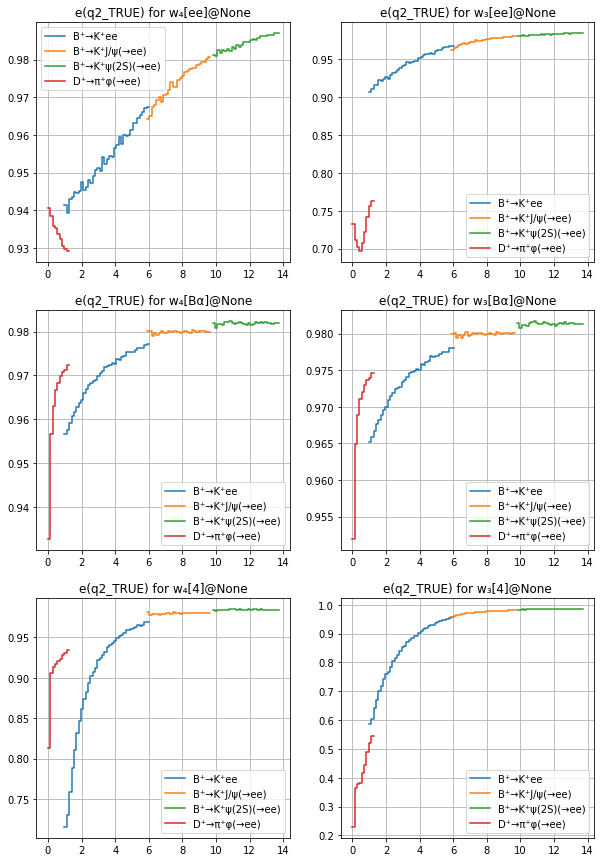

In [104]:
plot_e_all("q2_TRUE", results, np.linspace(0,14,101))

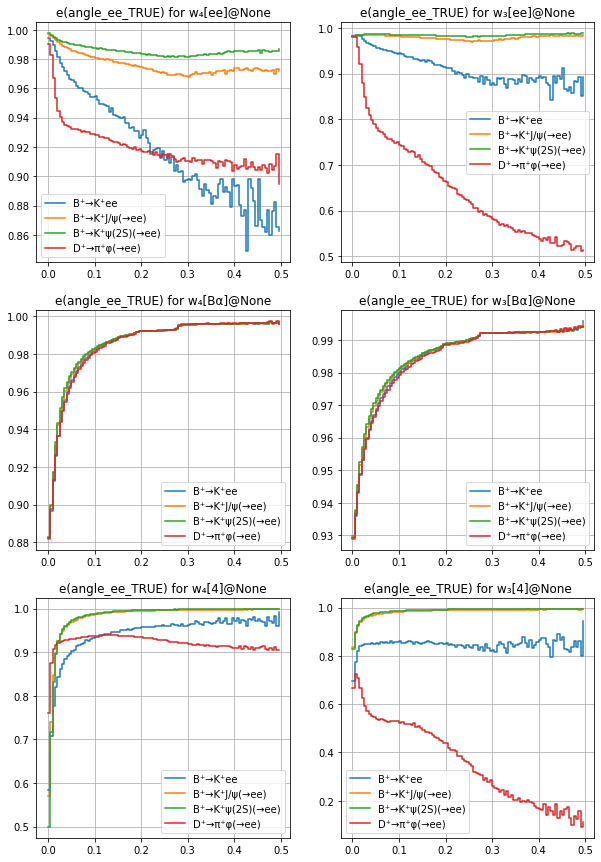

In [107]:
plot_e_all("angle_ee_TRUE", results, np.linspace(0,0.5,101))

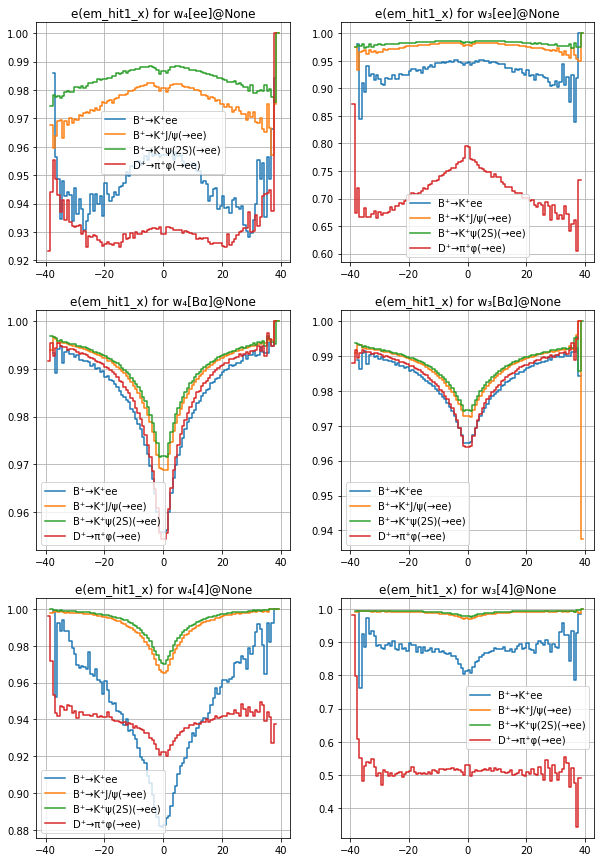

In [108]:
plot_e_all("em_hit1_x", results, np.linspace(-40,40,101))

### Blur

In [ ]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [ ]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

In [ ]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [ ]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [ ]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")

In [ ]:
tmp = _

In [ ]:
make_R(tmp.iloc[:,::2], "R-1,%").iloc[[0,2,3],:]